# Search-Based Test Generation

In [17]:
import random
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

## The Test Data Generation Problem

The problem we will consider in this chapter is the following: Given an entry point to a program (a function), we want to find values for the parameters of this function such that the execution of the function reaches a particular point in the program. In other words, we aim to find a test input to the program that covers a target statement. We will then generalise this problem to finding test inputs to cover _all_ statements in the program.

Assume we are aiming to test the following function under test:

In [18]:
def test_me(x, y):
    if x == 2 * (y + 1):
        return True
    else:
        return False

The `test_me` function has two input parameters, `x`and `y`, and it returns `True` or `False` depending on how the parameters relate:

In [19]:
test_me(10, 10)

False

In [20]:
test_me(22, 10)

True

In order to address the test generation problem as a search problem, we need to decide on an encoding, and derive appropriate search operators. It is possible to use bitvectors like we did on previous problems; however, a simpler interpretation of the parameters of a function is a list of the actual parameters. That is, we encode a test input as a list of parameters; we will start by assuming that all parameters are numeric.

The representation for inputs of this function is lists of length two, one element for `x` and one for `y`. As numeric values in Python are unbounded, we need to decide on some finite bounds for these values, e.g.:

In [21]:
MAX=1000
MIN=-MAX

For generating inputs we can now uniformly sample in the range (MIN, MAX). The length of the vector shall be the number of parameters of the function under test. Rather than hard coding such a parameter, we can also make our approach generalise better by using inspection to determine how many parameters the function under test has:

In [22]:
from inspect import signature
sig = signature(test_me)
num_parameters = len(sig.parameters)
num_parameters

2

As usual, we will define the representation implicitly using a function that produces random instances.

In [23]:
def get_random_solution():
    return [random.randint(MIN, MAX) for _ in range(num_parameters)]

In [24]:
get_random_solution()

[89, 160]

We need to define search operators matching this representation. To apply local search, we need to define the neighbourhood. For example, we could define one upper and one lower neighbour for each parameter:

- `x-1, y`
- `x+1, y`
- `x, y+1`
- `x, y-1`

In [25]:
def get_neighbours(individual):
    neighbours = []
    for p in range(len(individual)):
        if individual[p] > 0:
            neighbour = individual[:]
            neighbour[p] = individual[p] - 1
            neighbours.append(neighbour)
        if individual[p] < MAX:
            neighbour = individual[:]
            neighbour[p] = individual[p] - 1
            neighbours.append(neighbour)
            
    return neighbours

In [26]:
x = get_random_solution()
x

[756, 721]

In [27]:
get_neighbours(x)

[[755, 721], [755, 721], [756, 720], [756, 720]]

Before we can apply search, we also need to define a fitness function.  Suppose that we are interested in covering the `True` branch of the if-condition in the `test_me()` function, i.e. `x == 2 * (y + 1)`.

How close is a given input tuple for this function from reaching the target branch? Let's consider an arbitrary point in the search space, e.g. `(274, 153)`. The if-condition compares the following values:

In [28]:
x = 274
y = 153
x, 2 * (y + 1)

(274, 308)

In order to make the branch true, both values need to be the same. Thus, the more they differ, the further we are away from making the comparison true, and the less they differ, the closer we are from making the comparison true. Thus, we can quantify "how false" the comparison is by calculating the difference between `x` and `2 * (y + 1)`. Thus, we can calculate this distance as `abs(x - 2 * (y + 1))`:

In [29]:
def calculate_distance(x, y):
    return abs(x - 2 * (y + 1))

In [30]:
calculate_distance(274, 153)

34

We can use this distance value as our fitness function, since we can nicely measure how close we are to an optimal solution. Note, however, that "better" doesn't mean "bigger" in this case; the smaller the distance the better. This is not a problem, since any algorithm that can maximize a value can also be made to minimize it instead.

For each value in the search space of integer tuples, this distance value defines the elevation in our search landscape. Since our example search space is two-dimensional, the search landscape is three-dimensional and we can plot it to see what it looks like:

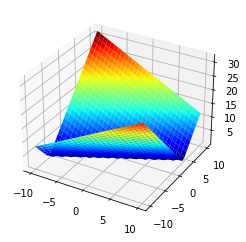

In [31]:
x = np.outer(np.linspace(-10, 10, 30), np.ones(30))
y = x.copy().T
z = calculate_distance(x, y)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0);

The optimal values, i.e. those that make the if-condition true, have fitness value 0 and can be clearly seen at the bottom of the plot. The further away from the optimal values, the higher elevated the points in the search space.

This distance can serve as our fitness function if we aim to cover the true branch of the program in our example:

In [32]:
def get_fitness(individual):
    x = individual[0]
    y = individual[1]
    return abs(x - 2 * (y + 1))

We can now use any local search algorithm we have defined previously, with only one modification: In the prior examples where we applied local search we were always maximising fitness values; now we are minimising, so a hillclimber, for example, should only move to neighbours with _smaller_ fitness values:

In [33]:
max_steps = 10000
fitness_values = []

Let's use a steepest ascent hillclimber:

In [34]:
def hillclimbing():

    current = get_random_solution()
    fitness = get_fitness(current)
    best = current[:]
    best_fitness = fitness
    print(f"Starting at fitness {best_fitness}: {current}")

    step = 0
    while step < max_steps and best_fitness > 0:
        neighbours = [(x, get_fitness(x)) for x in get_neighbours(current)]
        best_neighbour, neighbour_fitness = min(neighbours, key=lambda i: i[1])
        step += len(neighbours)        
        fitness_values.extend([best_fitness] * len(neighbours))
        if neighbour_fitness < fitness:
            current = best_neighbour
            fitness = neighbour_fitness
            if fitness < best_fitness:
                best = current[:]
                best_fitness = fitness
                #print(f"Iteration {step}, fitness {best_fitness}: {best}")
        else:
            # Random restart if no neighbour is better
            current = get_random_solution()
            fitness = get_fitness(current)
            step += 1
            if fitness < best_fitness:
                #print(f"Iteration {step}, fitness {best_fitness}: {best}")
                best = current[:]
                best_fitness = fitness
                fitness_values.append(best_fitness)


    print(f"Solution fitness after {step} fitness evaluations: {best_fitness}: {best}")
    return best

In [35]:
fitness_values = []
hillclimbing()

Starting at fitness 904: [-118, 392]
Solution fitness after 1296 fitness evaluations: 0: [-118, -60]


[-118, -60]

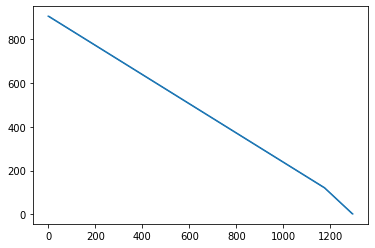

In [36]:
plt.plot(fitness_values)

Since there are no local optima, the hillclimber will easily find the solution, even without restarts. However, this can take a while, in particular if we use a larger input space:

In [37]:
MAX=100000
MIN=-MAX

Starting at fitness 43564: [-61296, -8867]
Solution fitness after 10000 fitness evaluations: 33564: [-61296, -13867]


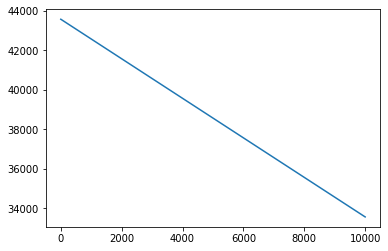

In [38]:
fitness_values = []
hillclimbing()
plt.plot(fitness_values)

Unless the randomly chosen initial point is already close to an optimal solution, the hillclimber is going to be hopeless in moving through the search space within a reasonable number of iterations.

## Alternating Variable Method

The search problem represented by the `test_me` function has an easy fitness landscape with no local optima. However, it still takes quite long to reach the optimum, depending on where the random starting point lies in the search space. This is because (1) the neighbourhood for real program inputs can be quite large, depending on the number of parameters, and (2) the search space for each parameter individually can already be very large. In our example we restricted `MAX` and `MIN` to a very narrow range, but imagine doing this for 32 bit integers. Both these problems are addressed with an adapted version of our hillclimber known as the _Alternating Variable Method_, which differs from the hillclimber in two ways: 
1. Rather than considering the neighbourhood of all input parameters at once, we apply search to each parameter individually in turn
2. Rather than taking only small steps of size 1, we allow larger jumps in the search space.

Let's first consider the second aspect, larger jumps in the search space. The idea is to apply a _pattern_ search where we first decide on a direction in the search space to move, and then apply increasingly larger steps in that direction as long as the fitness improves. We only consider a single parameter, thus the "direction" simply refers to whether one increases or decreases this value. The function thus takes (1) the individual on which to perform the search, (2) a particular parameter we are considering, (3) the direction of the search, and (4) the starting fitness values. 

In [39]:
def pattern_search(individual, parameter, direction, fitness):
    print(f"-> ({individual[0]}, {individual[1]}), direction {direction}, fitness {fitness}")

    individual[parameter] = individual[parameter] + 2 * direction
    new_fitness = get_fitness(individual)
    if new_fitness < fitness:
        fitness_values.append(new_fitness)
        return pattern_search(individual, parameter, 2 * direction, new_fitness)
    else:
        # If fitness is not better we overshot. Undo last move, and return
        fitness_values.append(fitness)
        individual[parameter] = individual[parameter] - 2 * direction
        return fitness

For example, let's assume `y` is a large value(1000), and `x` is considerably smaller. For our example function, the optimal value for `x` would thus be at 2200. Applying the search to `x` we thus need to move in the positive direction (`1`), and the function will do this with increasing steps until it "overshoots".

In [40]:
x = [0, 1000]
f = get_fitness(x)
pattern_search(x, 0, 1, get_fitness(x))

-> (0, 1000), direction 1, fitness 2002
-> (2, 1000), direction 2, fitness 2000
-> (6, 1000), direction 4, fitness 1996
-> (14, 1000), direction 8, fitness 1988
-> (30, 1000), direction 16, fitness 1972
-> (62, 1000), direction 32, fitness 1940
-> (126, 1000), direction 64, fitness 1876
-> (254, 1000), direction 128, fitness 1748
-> (510, 1000), direction 256, fitness 1492
-> (1022, 1000), direction 512, fitness 980
-> (2046, 1000), direction 1024, fitness 44


44

If `x` is larger than `y` we would need to move in the other direction, and the search does this until it undershoots the target of 2200:

In [41]:
x = [10000, 1000]
f = get_fitness(x)
pattern_search(x, 0, -1, get_fitness(x))

-> (10000, 1000), direction -1, fitness 7998
-> (9998, 1000), direction -2, fitness 7996
-> (9994, 1000), direction -4, fitness 7992
-> (9986, 1000), direction -8, fitness 7984
-> (9970, 1000), direction -16, fitness 7968
-> (9938, 1000), direction -32, fitness 7936
-> (9874, 1000), direction -64, fitness 7872
-> (9746, 1000), direction -128, fitness 7744
-> (9490, 1000), direction -256, fitness 7488
-> (8978, 1000), direction -512, fitness 6976
-> (7954, 1000), direction -1024, fitness 5952
-> (5906, 1000), direction -2048, fitness 3904
-> (1810, 1000), direction -4096, fitness 192


192

The AVM algorithm applies the pattern search as follows:
1. Start with the first parameter
2. Probe the neighbourhood of the parameter to find the direction of the search
3. Apply pattern search in that direction
4. Repeat probing + pattern search until no more improvement can be made
5. Move to the next parameter, and go to step 2

Like a regular hillclimber, the search may get stuck in local optima and needs to use random restarts. The algorithm is stuck if it probed all parameters in sequence and none of the parameters allowed a move that improved fitness.

In [42]:
def probe_and_search(individual, parameter, fitness):
    new_parameters = individual[:]
    value = new_parameters[parameter]
    new_fitness = fitness
    # Try +1
    new_parameters[parameter] = individual[parameter] + 1
    print(f"Trying +1 at fitness {fitness}: {new_parameters}")
    new_fitness = get_fitness(new_parameters)
    if new_fitness < fitness:
        fitness_values.append(new_fitness)
        new_fitness = pattern_search(new_parameters, parameter, 1, new_fitness)
    else:
        # Try -1
        fitness_values.append(fitness)
        new_parameters[parameter] = individual[parameter] - 1
        print(f"Trying -1 at fitness {fitness}: {new_parameters}")
        new_fitness = get_fitness(new_parameters)
        if new_fitness < fitness:
            fitness_values.append(new_fitness)
            new_fitness = pattern_search(new_parameters, parameter, -1, new_fitness)
        else:
            fitness_values.append(fitness)
            new_parameters[parameter] = individual[parameter]
            new_fitness = fitness
            
    return new_parameters, new_fitness

In [43]:
def avm():

    current = get_random_solution()
    fitness = get_fitness(current)
    best = current[:]
    best_fitness = fitness
    fitness_values.clear()
    fitness_values.append(best_fitness)
    print(f"Starting at fitness {best_fitness}: {current}")

    step = 0
    changed = True
    while len(fitness_values) < max_steps and best_fitness > 0:
        # Random restart
        if not changed:
            current = get_random_solution()
            print(f"Random restart at {current}")
            fitness = get_fitness(current)
            fitness_values.append(fitness)
            
        at_least_one_parameter_changed = True
        while at_least_one_parameter_changed:
            at_least_one_parameter_changed = False
            parameter = 0
            while parameter < len(current):
                print(f"Current parameter: {parameter}")
                new_parameters, new_fitness = probe_and_search(current, parameter, fitness)
                if current != new_parameters:
                    # Keep on searching
                    at_least_one_parameter_changed = True
                    current = new_parameters
                    fitness = new_fitness
                    if fitness < best_fitness:
                        best_fitness = fitness
                        best = current[:]
                else:
                    parameter += 1

    print(f"Solution fitness {best_fitness}: {best}")
    return best

In [44]:
fitness_values = []
avm()

Starting at fitness 138359: [-38819, -88590]
Current parameter: 0
Trying +1 at fitness 138359: [-38818, -88590]
Trying -1 at fitness 138359: [-38820, -88590]
-> (-38820, -88590), direction -1, fitness 138358
-> (-38822, -88590), direction -2, fitness 138356
-> (-38826, -88590), direction -4, fitness 138352
-> (-38834, -88590), direction -8, fitness 138344
-> (-38850, -88590), direction -16, fitness 138328
-> (-38882, -88590), direction -32, fitness 138296
-> (-38946, -88590), direction -64, fitness 138232
-> (-39074, -88590), direction -128, fitness 138104
-> (-39330, -88590), direction -256, fitness 137848
-> (-39842, -88590), direction -512, fitness 137336
-> (-40866, -88590), direction -1024, fitness 136312
-> (-42914, -88590), direction -2048, fitness 134264
-> (-47010, -88590), direction -4096, fitness 130168
-> (-55202, -88590), direction -8192, fitness 121976
-> (-71586, -88590), direction -16384, fitness 105592
-> (-104354, -88590), direction -32768, fitness 72824
-> (-169890, 

[-177178, -88590]

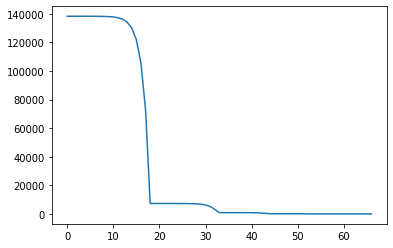

In [45]:
plt.plot(fitness_values)

The pattern search even works efficiently if we increase the size of the search space to 64-bit numbers:

In [46]:
MAX=2**32
MIN=-MAX

In [47]:
fitness_values = []
avm()

Starting at fitness 3487871581: [1212488299, -1137691642]
Current parameter: 0
Trying +1 at fitness 3487871581: [1212488300, -1137691642]
Trying -1 at fitness 3487871581: [1212488298, -1137691642]
-> (1212488298, -1137691642), direction -1, fitness 3487871580
-> (1212488296, -1137691642), direction -2, fitness 3487871578
-> (1212488292, -1137691642), direction -4, fitness 3487871574
-> (1212488284, -1137691642), direction -8, fitness 3487871566
-> (1212488268, -1137691642), direction -16, fitness 3487871550
-> (1212488236, -1137691642), direction -32, fitness 3487871518
-> (1212488172, -1137691642), direction -64, fitness 3487871454
-> (1212488044, -1137691642), direction -128, fitness 3487871326
-> (1212487788, -1137691642), direction -256, fitness 3487871070
-> (1212487276, -1137691642), direction -512, fitness 3487870558
-> (1212486252, -1137691642), direction -1024, fitness 3487869534
-> (1212484204, -1137691642), direction -2048, fitness 3487867486
-> (1212480108, -1137691642), di

[-2275383282, -1137691642]

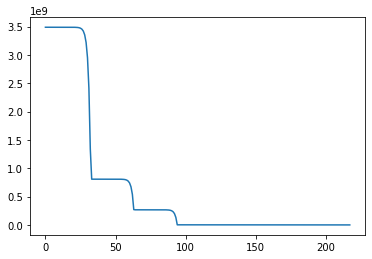

In [48]:
plt.plot(fitness_values)

## Program Instrumentation

Deriving fitness functions is not quite so easy. Of course we could come up with an equation that captures the relation between the sides of the triangle, but then essentially we would need to reproduce the entire program logic again in a function, which certainly does not help generalising to other programs. For example, consider how the fitness function would look like if the comparison was not made on the input parameters, but on values derived through computation within the function under test. Ideally, what we would want is to be able to pick a point in the program and come up with a fitness function automatically that describes how close we are to reaching this point.

There are two central ideas in order to achieve this:

- First, rather than trying to guess how close a program inputs gets to a target statement, we simply _run_ the program with the input and observe how close it actually gets.

- Second, during the execution we keep track of distance estimates like the one we calculated for the `test_me` function whenever we come across conditional statements.

In order to observe what an execution does, we need to *instrument* the program: We add new code immediately before or after the branching condition to keep track of the values observed and calculate the distance using these values.

Let's first consider what is done here conceptually. We first define a global variable in which we will store the distance, so that we can access it after the execution:

In [49]:
distance = 0

Now the instrumented version just has to update the global variable immediately before executing the branching condition:

In [50]:
def test_me_instrumented(x, y):
    global distance
    distance = calculate_distance(x, y)
    if x == 2 * (y + 1):
        return True
    else:
        return False

Let's try this out for a couple of example values:

In [51]:
test_me_instrumented(0, 0)
distance

2

In [52]:
test_me_instrumented(22, 10)
distance

0

Using this instrumented version of `test_me()`, we can a fitness function which simply calculates the distance for the condition being true:

In [53]:
def get_fitness(individual):
    global distance
    test_me_instrumented(*individual)
    fitness = distance
    return fitness

Let's try this on some example inputs:

In [54]:
get_fitness([0, 0])

2

When we have reached the target branch, the distance will be 0:

In [55]:
get_fitness([22, 10])

0

When implementing the instrumentation, we need to consider that the branching condition may have side-effects. For example, suppose that the branching condition were `x == 2 * foo(y)`, where `foo()` is a function that takes an integer as input. Naively instrumenting would lead to the following code:

```
    distance = abs(x - 2 * foo(y))
	if x == 2 * foo(y):
	...
```

Thus, the instrumentation would lead to `foo()` being executed *twice*. Suppose `foo()` changes the state of the system (e.g., by printing something, accessing the file system, changing some state variables, etc.), then clearly invoking `foo()` a second time is a bad idea. One way to overcome this problem is to _transform_ the conditions, rather than _adding_ tracing calls. For example, one can create temporary variables that hold the values necessary for the distance calculation and then use these in the branching condition:

```
	tmp1 = x
	tmp2 = 2 * foo(y)
	distance = compute_distance(tmp1, tmp2)
	if tmp1 == tmp2:
	...
```

In [56]:
def evaluate_equals(op1, op2):
    global distance
    distance = abs(op1 - op2)
    if distance == 0:
        return True
    else:
        return False;

Now the aim would be to transform the program automatically such that it looks like so:

In [57]:
def test_me_instrumented(x, y):
    tmp1 = x
    tmp2 = 2 * (y + 1)    
    if evaluate_equals(tmp1, tmp2):
        return True
    else:
        return False

Replacing comparisons automatically is actually quite easy in Python, using the abstract syntax tree (AST) of the program. In the AST, a comparison will typically be a tree node with an operator attribute and two children for the left-hand and right-hand operators. To replace such comparisons with a call to `calculate_distance()` one simply needs to replace the comparison node in the AST with a function call node, and this is what the `BranchTransformer` class does using a NodeTransformer from Python's `ast` module:

In [58]:
import ast

In [59]:
class BranchTransformer(ast.NodeTransformer):

    def visit_FunctionDef(self, node):
        node.name = node.name + "_instrumented"
        return self.generic_visit(node)

    def visit_Compare(self, node):
        if not isinstance(node.ops[0], ast.Eq):
            return node

        return ast.Call(func=ast.Name("evaluate_equals", ast.Load()),
                        args=[node.left,
                              node.comparators[0]],
                        keywords=[],
                        starargs=None,
                        kwargs=None)

The `BranchTransformer` parses a target Python program using the built-in parser `ast.parse()`, which returns the AST. Python provides an API to traverse and modify this AST. To replace the comparison with a function call we use an `ast.NodeTransformer`, which uses the visitor pattern where there is one `visit_*` function for each type of node in the AST. As we are interested in replacing comparisons, we override `visit_Compare`, where instead of the original comparison node we return a new node of type `ast.Func`, which is a function call node. The first parameter of this node is the name of the function `calculate_distance`, and the arguments are the two operands that our `calculate_distance` function expects.

You will notice that we also override `visit_FunctionDef`; this is just to change the name of the method by appending `_instrumented`, so that we can continue to use the original function together with the instrumented one.

The following code parses the source code of the `test_me()` function to an AST, then transforms it, and prints it out again (using the `to_source()` function from the `astor` library):

In [60]:
import inspect
import ast
import astor

In [61]:
source = inspect.getsource(test_me)
node = ast.parse(source)
BranchTransformer().visit(node)

# Make sure the line numbers are ok before printing
node = ast.fix_missing_locations(node)
print(astor.to_source(node))

def test_me_instrumented(x, y):
    if evaluate_equals(x, 2 * (y + 1)):
        return True
    else:
        return False



To calculate a fitness value with the instrumented version, we need to compile the instrumented AST again, which is done using Python's `compile()` function. We then need to make the compiled function accessible, for which we first retrieve the current module from `sys.modules`, and then add the compiled code of the instrumented function to the list of functions of the current module using `exec`. After this, the `cgi_decode_instrumented()` function can be accessed.

In [62]:
import sys

In [63]:
def create_instrumented_function(f):
    source = inspect.getsource(f)
    node = ast.parse(source)
    node = BranchTransformer().visit(node)

    # Make sure the line numbers are ok so that it compiles
    node = ast.fix_missing_locations(node)

    # Compile and add the instrumented function to the current module
    current_module = sys.modules[__name__]
    code = compile(node, filename="<ast>", mode="exec")
    exec(code, current_module.__dict__)

In [64]:
create_instrumented_function(test_me)

In [65]:
test_me_instrumented(0, 0)

False

In [66]:
distance

2

In [67]:
test_me_instrumented(22, 10)

True

In [68]:
distance

0

The estimate for any relational comparison of two values is defined in terms of the _branch distance_. Our `evaluate_equals` function indeed implements the branch distance function for an equality comparison. To generalise this we need similar estimates for other types of relational comparisons. Furthermore, we also have to consider the distance to such conditions evaluating to false, not just to true. Thus, each if-condition actually has two distance estimates, one to estimate how close it is to being true, and one how close it is to being false. If the condition is true, then the true distance is 0; if the condition is false, then the false distance is 0. That is, in a comparison `a == b`, if `a` is smaller than `b`, then the false distance is `0` by definition. 

The following table shows how to calculate the distance for different types of comparisons:

| Condition | Distance True | Distance False |
| ------------- |:-------------:| -----:|
| a == b      | abs(a - b) | 1 |
| a != b      | 1          | abs(a - b) |
| a < b       | b - a + 1  | a - b      |
| a <= b      | b - a      | a - b + 1  |
| a > b       | a - b + 1  | b - a      |


Note that several of the calculations add a constant `1`. The reason for this is quite simple: Suppose we want to have `a < b` evaluate to true, and let `a = 27` and `b = 27`. The condition is not true, but simply taking the difference would give us a result of `0`. To avoid this, we have to add a constant value. It is not important whether this value is `1` -- any positive constant works.

We generalise our `evaluate_equals` function to an `evaluate_condition` function that takes the operator as an additional parameter, and then implements the above table. In contrast to the previous `calculate_equals`, we will now calculate both, the true and the false distance:

In [69]:
def evaluate_condition(op, lhs, rhs):
    distance_true = 0
    distance_false = 0
    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    # ... code for other types of conditions

    if distance_true == 0:
        return True
    else:
        return False

Let's consider a slightly larger function under test. We will use the well known triangle example, originating in Glenford Meyer's classical Art of Software Testing book 

In [70]:
def triangle(a, b, c):
    if a <= 0 or b <= 0 or c <= 0:
        return 4 # invalid
    
    if a + b <= c or a + c <= b or b + c <= a:
        return 4 # invalid
    
    if a == b and b == c:
        return 1 # equilateral
    
    if a == b or b == c or a == c:
        return 2 # isosceles
    
    return 3 # scalene

The function takes as input the length of the three sides of a triangle, and returns a number representing the type of triangle:

In [71]:
triangle(4,4,4)

1

Adapting our representation is easy, we just need to correctly set the number of parameters:

In [72]:
sig = signature(triangle)
num_parameters = len(sig.parameters)
num_parameters

3

For the `triangle` function, however, we have multiple if-conditions; we have to add instrumentation to each of these using `evaluate_condition`. We also need to generalise from our global `distance` variable, since we now have two distance values per branch, and potentially multiple branches. Furthermore, a condition might be executed multiple times within a single execution (e.g., if it is in a loop), so rather than storing all values, we will only keep the _minimum_ value observed for each condition:

In [73]:
distances_true = {}
distances_false = {}

In [74]:
def update_maps(condition_num, d_true, d_false):
    global distances_true, distances_false

    if condition_num in distances_true.keys():
        distances_true[condition_num] = min(
            distances_true[condition_num], d_true)
    else:
        distances_true[condition_num] = d_true

    if condition_num in distances_false.keys():
        distances_false[condition_num] = min(
            distances_false[condition_num], d_false)
    else:
        distances_false[condition_num] = d_false

Now we need to finish implementing the `evaluate_condition` function. We add yet another parameter to denote the ID of the branch we are instrumenting:

In [75]:
def evaluate_condition(num, op, lhs, rhs):
    distance_true = 0
    distance_false = 0

    # Make sure the distance can be calculated on number and character
    # comparisons
    # TODO: Don't need that unless we use cgi_decode
    if isinstance(lhs, str):
        lhs = ord(lhs)
    if isinstance(rhs, str):
        rhs = ord(rhs)

    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    elif op == "Gt":
        if lhs > rhs:
            distance_false = lhs - rhs
        else:
            distance_true = rhs - lhs + 1
    elif op == "Lt":
        if lhs < rhs:
            distance_false = rhs - lhs
        else:
            distance_true = lhs - rhs + 1
    elif op == "LtE":
        if lhs <= rhs:
            distance_false = rhs - lhs + 1
        else:
            distance_true = lhs - rhs
    # ...
    # handle other comparison operators
    # ...

    elif op == "In":
        minimum = sys.maxsize
        for elem in rhs.keys():
            distance = abs(lhs - ord(elem))
            if distance < minimum:
                minimum = distance

        distance_true = minimum
        if distance_true == 0:
            distance_false = 1
    else:
        assert False

    update_maps(num, normalise(distance_true), normalise(distance_false))

    if distance_true == 0:
        return True
    else:
        return False

We need to normalise branch distances since different comparisons will be on different scales, and this would bias the search. We will use the normalisaction function defined in the previous chapter:

In [76]:
def normalise(x):
    return x / (1.0 + x)

We also need to extend our instrumentation function to take care of all comparisons, and not just equality comparisons:

In [77]:
import ast
class BranchTransformer(ast.NodeTransformer):

    branch_num = 0

    def visit_FunctionDef(self, node):
        node.name = node.name + "_instrumented"
        return self.generic_visit(node)

    def visit_Compare(self, node):
        if node.ops[0] in [ast.Is, ast.IsNot, ast.In, ast.NotIn]:
            return node

        self.branch_num += 1
        return ast.Call(func=ast.Name("evaluate_condition", ast.Load()),
                        args=[ast.Num(self.branch_num - 1),
                              ast.Str(node.ops[0].__class__.__name__),
                              node.left,
                              node.comparators[0]],
                        keywords=[],
                        starargs=None,
                        kwargs=None)

We can now take a look at the instrumented version of `triangle`:

In [78]:
source = inspect.getsource(triangle)
node = ast.parse(source)
transformer = BranchTransformer()
transformer.visit(node)

# Make sure the line numbers are ok before printing
node = ast.fix_missing_locations(node)
print(astor.to_source(node))
num_branches = transformer.branch_num

def triangle_instrumented(a, b, c):
    if evaluate_condition(0, 'LtE', a, 0) or evaluate_condition(1, 'LtE', b, 0
        ) or evaluate_condition(2, 'LtE', c, 0):
        return 4
    if evaluate_condition(3, 'LtE', a + b, c) or evaluate_condition(4,
        'LtE', a + c, b) or evaluate_condition(5, 'LtE', b + c, a):
        return 4
    if evaluate_condition(6, 'Eq', a, b) and evaluate_condition(7, 'Eq', b, c):
        return 1
    if evaluate_condition(8, 'Eq', a, b) or evaluate_condition(9, 'Eq', b, c
        ) or evaluate_condition(10, 'Eq', a, c):
        return 2
    return 3



To define an executable version of the instrumented triangle function, we can use our `create_instrumented_function` function again:

In [79]:
create_instrumented_function(triangle)

In [80]:
triangle_instrumented(4, 4, 4)

1

In [81]:
distances_true

{0: 0.8, 1: 0.8, 2: 0.8, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.0, 7: 0.0}

In [82]:
distances_false

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.5, 7: 0.5}

### Branch Distances

The branch distance functions above are defined only for atomic comparisons. However, in the `triangle` program all of the atomic comparisons are part of larger predicates, joined together by `and` and `or` connectors. 

For conjunctions the branch distance is defined such that the distance to make `A and B` true equals the sum of the branch distances for `A` and `B`, as both of the two conditions would need to be true. Similarly, the branch distance to make `A or B` true would be the _minimum_ of the two branch distances of `A` and `B`, as it suffices if one of the two conditions is true to make the entire expression true (and the false distance would be the sum of false distances of the conditions). For a negation `not A`, we can simply switch from the true distance to the false distance, or vice versa. Since predicates can consist of nested conditions, one would need to recursively calculate the branch distance.


Assume we want to find an input that covers the third if-condition, i.e., it produces a triangle where all sides have equal length. Considering instrumented version of the triangle function we printed above, in order for this if-condition to evaluate to true we require conditions 0, 1, 2, 3, 4, and 5 to evaluate to false, and 6 and 7 to evaluate to true. Thus, the fitness function for this branch would be the sum of false distances for branches 0-5, and true distances for branches 6 and 7.

In [83]:
def get_fitness(x):
    # Reset any distance values from previous executions
    global distances_true, distances_false
    distances_true = {x: 1.0 for x in range(10)}
    distances_false = {x: 1.0 for x in range(10)}

    # Run the function under test
    triangle_instrumented(*x)

    # Sum up branch distances
    fitness = 0.0
    for branch in [6, 7]:
        fitness += distances_true[branch]

    for branch in [0, 1, 2, 3, 4, 5]:
        fitness += distances_false[branch]

    return fitness

In [84]:
get_fitness([5,5,5])

0.0

In [85]:
get_fitness(get_random_solution())

4.999999998492432

In [86]:
MAX=10000
MIN=-MAX
fitness_values = []
max_gen = 1000
hillclimbing()

Starting at fitness 7.999889490551443: [-9047, -2993, -3862]
Solution fitness after 10005 fitness evaluations: 1.9995711835334475: [8249, 5918, 8527]


[8249, 5918, 8527]

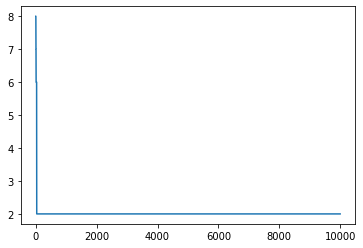

In [87]:
plt.plot(fitness_values)

In [88]:
fitness_values = []
avm()

Starting at fitness 7.999717673630717: [-3540, 5116, 2487]
Current parameter: 0
Trying +1 at fitness 7.999717673630717: [-3539, 5116, 2487]
-> (-3539, 5116), direction 1, fitness 7.999717593900028
-> (-3537, 5116), direction 2, fitness 7.999717434303475
-> (-3533, 5116), direction 4, fitness 7.9997171145685995
-> (-3525, 5116), direction 8, fitness 7.999716472923164
-> (-3509, 5116), direction 16, fitness 7.999715180860154
-> (-3477, 5116), direction 32, fitness 7.99971256108077
-> (-3413, 5116), direction 64, fitness 7.999707174231332
-> (-3285, 5116), direction 128, fitness 7.999695771219957
-> (-3029, 5116), direction 256, fitness 7.9996700758825465
-> (-2517, 5116), direction 512, fitness 7.999603017070266
-> (-1493, 5116), direction 1024, fitness 7.99933110367893
-> (555, 5116), direction 2048, fitness 3.999518304431599
-> (4651, 5116), direction 4096, fitness 1.9978540772532187
Current parameter: 0
Trying +1 at fitness 1.9978540772532187: [4652, 5116, 2487]
-> (4652, 5116), direc

[5116, 5116, 5116]

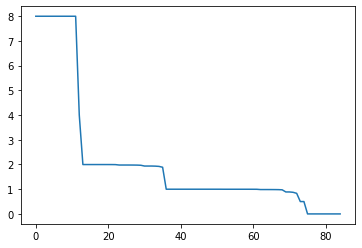

In [89]:
plt.plot(fitness_values)

Besides the local search algorithms, we can also use evolutionary search in order to find solutions to our test generation problem. We therefore need to define the usual search operators:

In [90]:
tournament_size=3
def tournament_selection(population, n=tournament_size):
    max_fitness = sys.maxsize
    winner = None
    for candidate in [random.choice(population) for _ in range(tournament_size)]:
        fitness = get_fitness(candidate)
        if fitness < max_fitness:
            winner = candidate
            max_fitness = fitness
    return winner

In [91]:
elite_size = 2
def elitism(population):
    population.sort(key=lambda k: get_fitness(k))
    return population[:elite_size]

In [92]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = solution[:]
    for position in range(len(solution)):
        if random.random() < P_mutate:
            mutated[position] = int(random.gauss(mutated[position], 20))
    return mutated

In [93]:
def singlepoint_crossover(parent1, parent2):
    pos = random.randint(0, len(parent1))
    offspring1 = parent1[:pos] + parent2[pos:]
    offspring2 = parent2[:pos] + parent1[pos:]
    return (offspring1, offspring2)

In [94]:
population_size = 20
P_xover = 0.7
max_gen = 100
selection = tournament_selection
crossover = singlepoint_crossover
MAX=1000
MIN=-MAX

In [95]:
def ga():
    population = [get_random_solution() for _ in range(population_size)]
    best_fitness = sys.maxsize
    for p in population:
        fitness = get_fitness(p)
        if fitness < best_fitness:
            best_fitness = fitness
            best_solution = p
    print("Iteration 0, best fitness: {}".format(best_fitness))

    for iteration in range(max_gen):
        fitness_values.append(best_fitness)
        new_population = elitism(population)
        while len(new_population) < len(population):
            parent1 = selection(population)
            parent2 = selection(population)

            if random.random() < P_xover:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)
            
            new_population.append(offspring1)
            new_population.append(offspring2)

        population = new_population
        for p in population:
            fitness = get_fitness(p)
            if fitness < best_fitness:
                best_fitness = fitness
                best_solution = p
        print(f"Iteration {iteration}, best fitness: {best_fitness}, size {len(best_solution)}")

    return best_solution

Iteration 0, best fitness: 1.9917355371900827
Iteration 0, best fitness: 1.99, size 3
Iteration 1, best fitness: 1.99, size 3
Iteration 2, best fitness: 1.9875, size 3
Iteration 3, best fitness: 1.967741935483871, size 3
Iteration 4, best fitness: 1.967741935483871, size 3
Iteration 5, best fitness: 1.9090909090909092, size 3
Iteration 6, best fitness: 1.8, size 3
Iteration 7, best fitness: 1.8, size 3
Iteration 8, best fitness: 1.5, size 3
Iteration 9, best fitness: 1.5, size 3
Iteration 10, best fitness: 1.5, size 3
Iteration 11, best fitness: 1.5, size 3
Iteration 12, best fitness: 1.5, size 3
Iteration 13, best fitness: 1.5, size 3
Iteration 14, best fitness: 1.5, size 3
Iteration 15, best fitness: 1.5, size 3
Iteration 16, best fitness: 1.5, size 3
Iteration 17, best fitness: 1.5, size 3
Iteration 18, best fitness: 0.0, size 3
Iteration 19, best fitness: 0.0, size 3
Iteration 20, best fitness: 0.0, size 3
Iteration 21, best fitness: 0.0, size 3
Iteration 22, best fitness: 0.0, siz

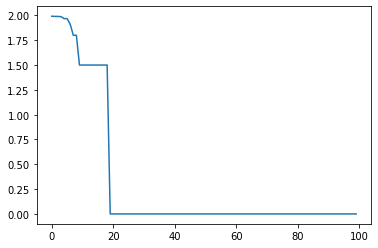

In [96]:
fitness_values = []
ga()
plt.plot(fitness_values)

In [97]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = solution[:]
    for position in range(len(solution)):
        if random.random() < P_mutate:
            if random.random() < 0.5:
                mutated[position] = int(random.gauss(mutated[position], 20))
            else:
                mutated[position] = random.randint(MIN, MAX)
    return mutated

TODO: Text about approach level etc.

## Many-Objective Optimisation

Besides the question of how the best fitness function for a coverage goal looks like, there are some related questions: How much time should we spend on optimising for each coverage goal? It is possible that some coverage goals are infeasible (e.g., dead code, or or infeasible branches), so any time spent on these is wasted, while it may be missing for other goals that are feasible but would need more time. Test cases typically cover multiple goals at the same time; even if a test is optimised for one specific line or branch, it may coincidentally cover others along the execution. Thus, the order in which we select coverage goals for optimisation may influence the overall result, and the number of tests we require. In principle, one way to address these issues would be by casting test generation as a multi-objective optimisation problem, and aiming to produce tests for _all_ coverage goals at the same time. However, there is an issue with this: Multi-objective algorithms like the ones we considered in the previous chapter typically work well on 2-3 objectives, but code will generally have many more coverage objectives, rendering classical multi-objective algorithms infeasible (Pareto-dominance happens rarely with higher numbers of objectives). We will therefore now consider some alternatives.

### Whole Test Suite Optimisation

The first alternative we consider is to switch our representation: Rather than optimising individual test cases for individual coverage objectives, we optimise entire test _suites_ to cover _all_ coverage objectives at the same time. Our encoding thus should describe multiple tests. But how many? This is very much problem specific. Thus, rather than hard coding the number of tests, we will only define an upper bound, and let the search decide what is the necessary number of tests.

In [162]:
num_tests = 30

In [163]:
def get_random_solution():
    num = random.randint(1, num_tests)
    return [[random.randint(MIN, MAX) for _ in range(num_parameters)] for _ in range(num)]

When applying mutation, we need to be able to modify individual tests as before:

In [164]:
def mutate_test(solution):
    P_mutate = 1/len(solution)
    mutated = solution[:]
    for position in range(len(solution)):
        if random.random() < P_mutate:
            mutated[position] = int(random.gauss(mutated[position], 20))
            
    return mutated

However, modifying tests is only one of the things we can do when mutating our actual individuals, which consist of multiple tests. Besides modifying existing tests, we can also delete or add tests:

In [165]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = []
    for position in range(len(solution)):
        if random.random() >= P_mutate:
            mutated.append(solution[position][:])

    for position in range(len(mutated)):
        if random.random() < P_mutate:
            mutated[position] = mutate_test(mutated[position])

    ALPHA = 0.1
    count = 1
    while random.random() < ALPHA ** count and len(mutated) < num_tests:
        count += 1
        mutated.append([random.randint(MIN, MAX) for _ in range(num_parameters)])
    
    return mutated

With a certain probability, each of the tests can be removed from a test suite; similarly, each remaining test may be mutated like we mutated tests previously. Finally, with a probability `ALPHA` we insert a new test; if we do so, we insert another one with probability `ALPHA`$^2$, and so on.

The variable size has some knock-on effects. In particular, we need to make sure that our individuals don't grow without bounds, so we adapt the other operators accordingly. When applying crossover, we pick a relative position and then cut the individuals at their relative position, such that no offspring becomes longer than the longest parent:

In [166]:
def relative_crossover(parent1, parent2):
    pos = random.random()
    pos1 = int(len(parent1) * pos)
    pos2 = int(len(parent2) * pos)
    offspring1 = parent1[:pos1] + parent2[pos2:]
    offspring2 = parent2[:pos2] + parent1[pos1:]
    return (offspring1, offspring2)

When selecting individuals, we apply a secondary criterion: For any two individuals with equal fitness function, we prefer the shorter one:

In [167]:
tournament_size = 4
def tournament_selection(population, n=tournament_size):
    min_fitness = sys.maxsize
    min_size = sys.maxsize
    winner = None
    for candidate in [random.choice(population) for _ in range(tournament_size)]:
        fitness = get_fitness(candidate)
        size = len(candidate)
        if fitness < min_fitness:
            winner      = candidate
            min_fitness = fitness
            min_size    = size
        elif fitness == min_fitness and size < min_size:
            winner = candidate
            min_fitness = fitness
            min_size = size
                
    return winner

The criterion also has to hold when we apply elitism -- we don't only want the test suites with the best fitness, but we also want the smallest test suites:

In [168]:
elite_size = 2
def elitism(population):
    population.sort(key=lambda k: (get_fitness(k), len(k)))
    return population[:elite_size]

Finally, the only thing that remains to be done is defining the fitness function. Since we want to cover _everything_ we simply need to make sure that every single branch is covered at least once in a test suite. A branch is covered if its minimum branch distance is 0; thus, if everything is covered, then the sum of minimal branch distances should be 0.

There is one special case: If an if-statement is executed only once, then optimising the true/false distance may lead to a suboptimal, oscillising evolution. We therefore also count how often each if-condition was executed. If it was only executed once, then the fitness value for that branch needs to be higher than if it was executed twice. For this, we extend our `update_maps` function to also keep track of the execution count:

In [169]:
condition_count = {}
def update_maps(condition_num, d_true, d_false):
    global distances_true, distances_false, condition_count

    if condition_num in condition_count.keys():
        condition_count[condition_num] = condition_count[condition_num] + 1
    else:
        condition_count[condition_num] = 1
        
    if condition_num in distances_true.keys():
        distances_true[condition_num] = min(
            distances_true[condition_num], d_true)
    else:
        distances_true[condition_num] = d_true

    if condition_num in distances_false.keys():
        distances_false[condition_num] = min(
            distances_false[condition_num], d_false)
    else:
        distances_false[condition_num] = d_false

The actual fitness function now is the sum of minimal distances after all tests have been executed. If an if-condition was not executed at all, then the true distance and the false distance will be 1, resulting in a sum of 2 for the if-condition. If the condition was covered only once, we set the fitness to exactly 1. If the condition was executed more than once, then at least either the true or false distance has to be 0, such that in sum, true and false distances will be less than 0.

In [170]:
def get_fitness(x):
    # Reset any distance values from previous executions
    global distances_true, distances_false, condition_count
    distances_true =  {x: 1.0 for x in range(num_branches)}
    distances_false = {x: 1.0 for x in range(num_branches)}
    condition_count = {x:   0 for x in range(num_branches)}

    # Run the function under test
    for test in x:
        triangle_instrumented(*test)

    # Sum up branch distances
    fitness = 0.0
    for branch in range(num_branches):
        if condition_count[branch] == 1:
            fitness += 1
        else:
            fitness += distances_true[branch]
            fitness += distances_false[branch]

    return fitness

TODO: Maybe try first with just random replacement, and add swap mutation later?

In [171]:
max_gen=500
MAX=1000
MIN=-MAX
crossover = relative_crossover
population_size = 50
fitness_values = []
ga()

Iteration 0, best fitness: 5.949138265823596
Iteration 0, best fitness: 5.942246773731496, size 29
Iteration 1, best fitness: 5.942246773731496, size 29
Iteration 2, best fitness: 4.977435897435898, size 22
Iteration 3, best fitness: 4.977435897435898, size 22
Iteration 4, best fitness: 3.9957446808510637, size 22
Iteration 5, best fitness: 3.9957446808510637, size 22
Iteration 6, best fitness: 3.9957446808510637, size 22
Iteration 7, best fitness: 3.9957446808510637, size 22
Iteration 8, best fitness: 3.9957446808510637, size 22
Iteration 9, best fitness: 3.9957446808510637, size 22
Iteration 10, best fitness: 3.995594713656388, size 16
Iteration 11, best fitness: 3.995594713656388, size 16
Iteration 12, best fitness: 3.995594713656388, size 16
Iteration 13, best fitness: 3.995594713656388, size 16
Iteration 14, best fitness: 3.995594713656388, size 16
Iteration 15, best fitness: 3.995594713656388, size 16
Iteration 16, best fitness: 3.9953488372093022, size 12
Iteration 17, best fitn

Iteration 190, best fitness: 1.0, size 10
Iteration 191, best fitness: 1.0, size 10
Iteration 192, best fitness: 1.0, size 10
Iteration 193, best fitness: 1.0, size 10
Iteration 194, best fitness: 1.0, size 10
Iteration 195, best fitness: 1.0, size 10
Iteration 196, best fitness: 1.0, size 10
Iteration 197, best fitness: 1.0, size 10
Iteration 198, best fitness: 1.0, size 10
Iteration 199, best fitness: 1.0, size 10
Iteration 200, best fitness: 1.0, size 10
Iteration 201, best fitness: 1.0, size 10
Iteration 202, best fitness: 1.0, size 10
Iteration 203, best fitness: 1.0, size 10
Iteration 204, best fitness: 1.0, size 10
Iteration 205, best fitness: 1.0, size 10
Iteration 206, best fitness: 1.0, size 10
Iteration 207, best fitness: 1.0, size 10
Iteration 208, best fitness: 1.0, size 10
Iteration 209, best fitness: 1.0, size 10
Iteration 210, best fitness: 1.0, size 10
Iteration 211, best fitness: 1.0, size 10
Iteration 212, best fitness: 1.0, size 10
Iteration 213, best fitness: 1.0, 

Iteration 381, best fitness: 0.9973333333333333, size 12
Iteration 382, best fitness: 0.9973333333333333, size 12
Iteration 383, best fitness: 0.9973333333333333, size 12
Iteration 384, best fitness: 0.9973333333333333, size 12
Iteration 385, best fitness: 0.9973333333333333, size 12
Iteration 386, best fitness: 0.9973333333333333, size 12
Iteration 387, best fitness: 0.9973333333333333, size 12
Iteration 388, best fitness: 0.9973333333333333, size 12
Iteration 389, best fitness: 0.9973333333333333, size 12
Iteration 390, best fitness: 0.9973333333333333, size 12
Iteration 391, best fitness: 0.9973333333333333, size 12
Iteration 392, best fitness: 0.9973333333333333, size 12
Iteration 393, best fitness: 0.9973333333333333, size 12
Iteration 394, best fitness: 0.9973333333333333, size 12
Iteration 395, best fitness: 0.9973333333333333, size 12
Iteration 396, best fitness: 0.9973333333333333, size 12
Iteration 397, best fitness: 0.9973333333333333, size 12
Iteration 398, best fitness: 0.

[[496, 496, 198],
 [496, 496, 53],
 [396, 684, 396],
 [114, 458, 876],
 [492, 762, 246],
 [121, -458, 655],
 [706, 197, 189],
 [443, 376, 376],
 [483, 368, 341],
 [-389, 1011, -543],
 [921, 183, -256]]

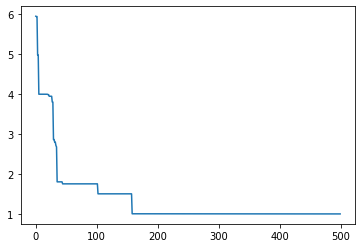

In [172]:
plt.plot(fitness_values)

Done, now run GA

### MOSA

In [554]:
class L(list):
    """
    A subclass of list that can accept additional attributes.
    Should be able to be used just like a regular list.
    """
    def __new__(self, *args, **kwargs):
        return super(L, self).__new__(self, args, kwargs)

    def __init__(self, *args, **kwargs):
        if len(args) == 1 and hasattr(args[0], '__iter__'):
            list.__init__(self, args[0])
        else:
            list.__init__(self, args)
        self.__dict__.update(kwargs)

    def __call__(self, **kwargs):
        self.__dict__.update(kwargs)
        return self

In [574]:
def evaluate(individual):
    global distances_true, distances_false
    distances_true =  {x: 1.0 for x in range(num_branches)}
    distances_false = {x: 1.0 for x in range(num_branches)}

    triangle_instrumented(*individual)

    individual.true_distance = {}
    individual.false_distance = {}
    for b in range(num_branches):
        individual.true_distance[b] = distances_true[b]
        individual.false_distance[b] = distances_false[b]

In [585]:
def dominates(solution1, solution2):
    for b in range(num_branches):
        if solution1.true_distance[b] > solution2.true_distance[b]:
            return False
        if solution1.false_distance[b] > solution2.false_distance[b]:
            return False

    for b in range(num_branches):
        if solution1.true_distance[b] < solution2.true_distance[b]:
            return True
        if solution1.false_distance[b] < solution2.false_distance[b]:
            return True

    return False

In [769]:
def get_random_individual():
    individual = L([random.randint(MIN, MAX) for _ in range(num_parameters)])
    evaluate(individual)
    return individual

In [770]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = L(solution[:])
    for position in range(len(solution)):
        if random.random() < P_mutate:
            mutated[position] = random.randint(MIN, MAX)
    evaluate(mutated)
    return mutated

In [576]:
def get_initial_population():
    population = [get_random_individual() for _ in range(population_size)]    
    return population

In [591]:
def binary_rank_tournament(population):
    individual1 = random.choice(population)
    individual2 = random.choice(population)

    if individual1.rank < individual2.rank:
        return individual1
    elif individual1.rank > individual2.rank:
        return individual2
    else:
        for b in range(num_branches):
            if individual1.true_distance[b] != individual2.true_distance[b]:
                return min([individual1, individual2], key = lambda i: i.true_distance[b])
            if individual1.true_distance[b] != individual2.true_distance[b]:
                return min([individual1, individual2], key = lambda i: i.false_distance[b])
    return random.choice([individual1, individual2])

In [560]:
def generate_offspring(population):
    offspring_population = []
    while len(offspring_population) < len(population):
        parent1 = binary_rank_tournament(population)
        parent2 = binary_rank_tournament(population)
        if random.random() < P_xover:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2
            
        offspring1 = mutate(offspring1)
        offspring2 = mutate(offspring2)

        offspring_population.append(offspring1)
        offspring_population.append(offspring2)

    return offspring_population

In [618]:
def update_archive(archive, population):
    
    # Ignores secondary criterion because length is fixed here
    for b in range(num_branches):        
        if b not in archive:
            archive[b] = {}
        if True not in archive[b].keys():
            for t in population:
                if t.true_distance[b] == 0:
                    archive[b][True] = t
                    print(f"Covered branch {b}/True: {t}")
                    break
        if False not in archive[b].keys():
            for t in population:
                 if t.false_distance[b] == 0:
                    archive[b][False] = t
                    print(f"Covered branch {b}/False: {t}")
                    break


In [562]:
def fast_non_dominated_sort(solutions):
    front = [[]]

    S = [[] for _ in range(len(solutions))]
    n = [0 for _ in range(len(solutions))]

    for p in range(len(solutions)):
        S[p] = []
        n[p] = 0
        for q in range(len(solutions)):
            if dominates(solutions[p], solutions[q]):
                S[p].append(q)
            elif dominates(solutions[q], solutions[p]):
                n[p] = n[p] + 1

        if n[p] == 0:
            front[0].append(p)
            solutions[p].rank = 0

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] = n[q] - 1
                if n[q] == 0:
                    Q.append(q)
                    solutions[q].rank = i + 1
        i = i + 1
        front.append(Q)

    del front[len(front) - 1]
    return front

In [587]:
def preference_sorting(population, archive):
    # First front consists of best test per branch
    
    fronts = []
    f0 = []
    uncovered_branches = []
    # Only consider uncovered branches?
    for b in range(num_branches):
        if b not in archive.keys() or True not in archive[b].keys():
            # Add test with minimum objetive score for b to f0
            best = min(population, key=lambda t: t.true_distance[b])
            if best not in f0:
                f0.append(best)
        if b not in archive.keys() or False not in archive[b].keys():
            # Add test with minimum objetive score for b to f0
            best = min(population, key=lambda t: t.false_distance[b])
            if best not in f0:
                f0.append(best)

    for t in f0:
        t.rank = 0
    
    fronts.append(f0)
    
    remaining = [x for x in population if not x in f0]
    
    # Remaining tests: 
    if remaining:
        # Calculate non-dominance only using uncovered branches
        remaining_fronts = fast_non_dominated_sort(remaining)
        for i in range(len(remaining_fronts)):
            front = [remaining[index] for index in remaining_fronts[i]]
            for t in front:
                t.rank = i + 1
            fronts.append(front)
    
    return fronts

In [614]:
def calculate_crowding_distance_and_sort(front):

    if not front:
        return
    distance = [0 for _ in range(0,len(front))]

    for b in range(num_branches):
        data = [(x, front[x].true_distance[b]) for x in range(len(front))]
        sorted_front = sorted(data, key=lambda tup: tup[1])
        range_fitness = sorted_front[-1][1] - sorted_front[0][1]
        if range_fitness > 0.0:
            distance[sorted_front[0][0]] = sys.maxsize
            distance[sorted_front[-1][0]] = sys.maxsize

            for k in range(1,len(front)-1):
                index = sorted_front[k][0]
                distance[index] = distance[index] + (sorted_front[k+1][1] - sorted_front[k-1][1]) / range_fitness

        data = [(x, front[x].false_distance[b]) for x in range(len(front))]
        sorted_front = sorted(data, key=lambda tup: tup[1])
        range_fitness = sorted_front[-1][1] - sorted_front[0][1]
        if range_fitness > 0.0:
            distance[sorted_front[0][0]] = sys.maxsize
            distance[sorted_front[-1][0]] = sys.maxsize

            for k in range(1,len(front)-1):
                index = sorted_front[k][0]
                distance[index] = distance[index] + (sorted_front[k+1][1] - sorted_front[k-1][1]) / range_fitness

    for k in range(0, len(front)):
        front[k].distance = distance[k]

    front.sort(key = lambda i: i.distance, reverse=True)

In [631]:
def mosa():
    population = get_initial_population()
    archive = {}
    update_archive(archive, population)
    preference_sorting(population, archive)


    for iteration in range(max_gen):
        uncovered = 0
        for b in range(num_branches):
            if b not in archive.keys() or True not in archive[b].keys():
                uncovered += 1
            if b not in archive.keys() or False not in archive[b].keys():
                uncovered += 1
        print(f"Iteration {iteration}, missing branches: {uncovered}")
        if uncovered == 0:
            break        

        offspring_population = generate_offspring(population)
        combined = population + offspring_population
        
        fronts = preference_sorting(combined, archive)
        population = []

        for front in fronts:
            calculate_crowding_distance_and_sort(front)

            for t in front:
                population.append(t)
                if len(population) == population_size:
                    break
            if len(population) == population_size:
                break

        update_archive(archive, population)
        

    return archive

In [633]:
max_gen=500
MAX=1000
MIN=-MAX
result = mosa()
print(result)
for branch, res in result.items():
    for (value, test) in res.items():
        print(f"Branch {branch}, value {value}: {test}")

Covered branch 0/True: [-189, -778, 635]
Covered branch 0/False: [950, -604, 917]
Covered branch 1/True: [950, -604, 917]
Covered branch 1/False: [180, 543, -927]
Covered branch 2/True: [180, 543, -927]
Covered branch 2/False: [791, 567, 369]
Covered branch 3/False: [791, 567, 369]
Covered branch 4/True: [745, 852, 9]
Covered branch 4/False: [791, 567, 369]
Covered branch 5/False: [791, 567, 369]
Covered branch 6/False: [791, 567, 369]
Covered branch 8/False: [791, 567, 369]
Covered branch 9/False: [791, 567, 369]
Covered branch 10/False: [791, 567, 369]
Iteration 0, missing branches: 8
Iteration 1, missing branches: 8
Covered branch 3/True: [180, 543, 757]
Covered branch 5/True: [791, 35, 298]
Iteration 2, missing branches: 6
Iteration 3, missing branches: 6
Iteration 4, missing branches: 6
Covered branch 9/True: [115, 582, 582]
Iteration 5, missing branches: 5
Iteration 6, missing branches: 5
Iteration 7, missing branches: 5
Iteration 8, missing branches: 5
Iteration 9, missing branc

### MIO

The MIO algorithm maintains an archive of tests. In the archive, for each
testing target we keep a different population of tests of size up to n (e.g, n = 10).
Therefore, given z objectives/targets, there can be up to n×z tests in the archive
at the same time.

At the beginning of the search, the archive will be empty, and so a new test
will be randomly generated. From the second step on, MIO will decide to either
sample a new test at random (probability Pr), or will choose (details later) one
existing test in the archive (probability 1 − Pr), copy it, and mutate it. 

Every time a new test is sampled/mutated, its fitness is calculated, and it will be saved in the archive if needed.





In [671]:
class Goal:
    def __init__(self, branch, value):
        self.branch = branch
        self.value  = value
    
    def get_distance(self, test):
        if self.value:
            return test.true_distance[self.branch]
        else:
            return test.false_distance[self.branch]
    
    def is_coveredby(self, test):
        return self.get_distance(test) == 0
    
    def __str__(self):
        return f"Branch {self.branch}/{self.value}"

In [672]:
#from collections import namedtuple
#Goal = namedtuple("Goal", "branch value")
goals = [Goal(num, val) for num in range(num_branches) for val in [True, False]]

In [755]:
archive_size = 10
def update_archive(archive, t):
    for goal in goals:
        if goal in archive and len(archive[goal]) == 1 and goal.is_coveredby(archive[goal][0]):
            continue
        h = goal.get_distance(t)
        if h == 0:
            # Keep only that test
            # TODO: Keep only shorter one
            if goal not in archive:
                print(f"Goal {goal} covered by {t}")
                archive[goal] = [t]
            elif len(archive[goal]) != 1 or not goal.is_coveredby(archive[goal][0]):
                print(f"Goal {goal} covered by {t}")
                archive[goal] = [t]
        elif h < 1:
            if goal not in archive:
                archive[goal] = [t]
            elif len(archive[goal]) < archive_size:
                # TODO: No duplicates
                archive[goal].append(t)
            elif h < goal.get_distance(archive[goal][-1]):
                # Replace worst, if this one is better
                del archive[goal][-1]
                archive[goal].append(t)
                
            archive[goal].sort(key = lambda t: goal.get_distance(t))

In [775]:
def sample_archive(archive):
    uncovered_goals = []
    for goal, tests in archive.items():
        if len(tests) == 1 and goal.is_coveredby(tests[0]):
            continue
        elif len(tests) > 0:
            uncovered_goals.append(goal)
            
    if not uncovered_goals:
        for goal, tests in archive.items():
            if len(tests) > 0:
                uncovered_goals.append(goal)
                
    goal = random.choice(uncovered_goals)
    
    # Now choose one test randomly for "goal" in archive
    return random.choice(archive[goal])

In [785]:
sample_counter = {}

In [877]:
archive_size = 10
def update_archive(archive, t):
    for goal in goals:
        if goal in archive and len(archive[goal]) == 1 and goal.is_coveredby(archive[goal][0]):
            continue
        h = goal.get_distance(t)
        if h == 0:
            # Keep only that test
            # TODO: Keep only shorter one
            if goal not in archive:
                print(f"Goal {goal} covered by {t}")
                archive[goal] = [t]
                sample_counter[goal] = 0
            elif len(archive[goal]) != 1 or not goal.is_coveredby(archive[goal][0]):
                print(f"Goal {goal} covered by {t}")
                archive[goal] = [t]
                sample_counter[goal] = 0
        elif h < 1:
            if goal not in archive:
                archive[goal] = [t]
                sample_counter[goal] = 0
            elif len(archive[goal]) < archive_size:
                # TODO: No duplicates
                archive[goal].append(t)
                sample_counter[goal] = 0
            elif h < goal.get_distance(archive[goal][-1]):
                # Replace worst, if this one is better
                del archive[goal][-1]
                archive[goal].append(t)
                sample_counter[goal] = 0
                
            archive[goal].sort(key = lambda t: goal.get_distance(t))

In [917]:

def sample_archive(archive):
    uncovered_goals = []    
    for goal, tests in archive.items():
        if len(tests) == 1 and goal.is_coveredby(tests[0]):
            continue
        elif len(tests) > 0:
            uncovered_goals.append(goal)
            
    if not uncovered_goals:        
        for goal, tests in archive.items():            
            if len(tests) > 0:
                uncovered_goals.append(goal)
                
    random.shuffle(uncovered_goals)
    uncovered_goals.sort(key = lambda g: sample_counter[g])
    #for goal in uncovered_goals:
    #    print(f"  Goal {goal}: {sample_counter[goal]}")
    goal = uncovered_goals[0]
    if focused:
        print(f"Chosen goal: {goal} with {len(archive[goal])} tests")
    sample_counter[goal] += 1
    # Now choose one test randomly for "goal" in archive
    return random.choice(archive[goal])

In [788]:
def get_solutions(archive):
    test_suite = []
    for goal, tests in archive.items():
        if len(tests) == 1 and goal.is_coveredby(tests[0]):
            test_suite.append(tests[0])
    return test_suite

In [817]:
P_sample = 0.7
F = 0.5

def mio():
    archive = {}
    
    for step in range(max_gen * population_size):
        #if step % population_size == 0:
        #    print(f"Iteration {step}")
        if random.random() < P_sample or len(archive) == 0:
            current = get_random_individual()
        else:
            current = sample_archive(archive)
            current = mutate(current)

        update_archive(archive, current)
        
    return get_solutions(archive)
    

In [878]:
sample_counter = {}
result = mio()
print(len(result))
result

Goal Branch 0/True covered by [-178, -476, -214]
Changing archive size to 9
Goal Branch 0/False covered by [231, -228, -657]
Goal Branch 1/True covered by [231, -228, -657]
Goal Branch 1/False covered by [231, 566, 152]
Goal Branch 2/False covered by [231, 566, 152]
Goal Branch 3/False covered by [231, 566, 152]
Goal Branch 4/True covered by [231, 566, 152]
Goal Branch 4/False covered by [946, 751, 343]
Goal Branch 5/False covered by [946, 751, 343]
Goal Branch 6/False covered by [946, 751, 343]
Goal Branch 8/False covered by [946, 751, 343]
Goal Branch 9/False covered by [946, 751, 343]
Goal Branch 10/False covered by [946, 751, 343]
Goal Branch 5/True covered by [946, 751, 136]
Goal Branch 2/True covered by [337, 696, -975]
Goal Branch 3/True covered by [728, 200, 966]
Changing archive size to 8
Changing num mutations to 2
Changing archive size to 7
Changing num mutations to 3
Goal Branch 9/True covered by [543, 498, 498]
Changing archive size to 6
Changing num mutations to 4
Changin

[[-178, -476, -214],
 [231, -228, -657],
 [231, -228, -657],
 [231, 566, 152],
 [337, 696, -975],
 [231, 566, 152],
 [728, 200, 966],
 [231, 566, 152],
 [231, 566, 152],
 [946, 751, 343],
 [946, 751, 136],
 [946, 751, 343],
 [563, 563, 653],
 [946, 751, 343],
 [563, 563, 653],
 [946, 751, 343],
 [543, 498, 498],
 [946, 751, 343],
 [465, 44, 465],
 [946, 751, 343],
 [563, 563, 653]]

In [902]:
P_sample_focused = 0
P_sample_first = 0.5

archive_size_focused = 10
archive_size_first = 10

mutations_focused = 10
mutations_first = 1

F = 0.5

In [898]:
focused = False
def update_parameters(steps, archive):
    global focused, P_sample, archive_size, num_mutations, F
    progress = steps / (max_gen * population_size)
    progress_until_focused = progress / F;
    if progress > F:
        P_sample = P_sample_focused
        archive_size = archive_size_focused
        num_mutations = mutations_focused
        if not focused:
            print(f"Entering focused phase")
            focused = True
    else:
        pps = P_sample
        pas = archive_size
        pnm = num_mutations
        
        P_sample = P_sample_first + (P_sample_focused - P_sample_first) * progress_until_focused
        archive_size = int(archive_size_first + (archive_size_focused - archive_size_first) * progress_until_focused)
        num_mutations = int(mutations_first + (mutations_focused - mutations_first) * progress_until_focused)
        
        #if pps != P_sample:
        #    print(f"Changing sampling probability to {P_sample}")
        if pas != archive_size:
            print(f"Changing archive size to {archive_size}")
            for goal in goals:
                if goal in archive:
                    while len(archive[goal]) > archive_size:                    
                        del archive[goal][-1]
                
        if pnm != num_mutations:
            print(f"Changing num mutations to {num_mutations}")
        
        
        # Crop archives if necessary

In [909]:
def update_archive(archive, t):
    updated = False
    for goal in goals:
        if goal in archive and len(archive[goal]) == 1 and goal.is_coveredby(archive[goal][0]):
            continue
        h = goal.get_distance(t)
        if h == 0:
            # Keep only that test
            # TODO: Keep only shorter one
            if goal not in archive:
                print(f"Goal {goal} covered by {t}")
                archive[goal] = [t]
                sample_counter[goal] = 0
                updated = True
            elif len(archive[goal]) != 1 or not goal.is_coveredby(archive[goal][0]):
                print(f"Goal {goal} covered by {t}")
                archive[goal] = [t]
                sample_counter[goal] = 0
                updated = True
        elif h < 1:
            if goal not in archive:
                archive[goal] = [t]
                sample_counter[goal] = 0
                updated = True
            elif len(archive[goal]) < archive_size:
                # TODO: No duplicates
                archive[goal].append(t)
                sample_counter[goal] = 0
                updated = True
            elif h < goal.get_distance(archive[goal][-1]):
                # Replace worst, if this one is better
                del archive[goal][-1]
                archive[goal].append(t)
                updated = True
                sample_counter[goal] = 0
                
            archive[goal].sort(key = lambda t: goal.get_distance(t))
    return updated

In [931]:
import copy
P_sample = 0.7
archive_size = 10
num_mutations = 1
F = 0.5
def mio():
    archive = {}
    update_parameters(0, archive)
    current_mutations = 0
    current = None
    
    for step in range(max_gen * population_size):
        if current and current_mutations < num_mutations:
            offspring = mutate(current)
            if focused:
                print(f"Mutating {current_mutations}: {current}/{current.true_distance[7]} -> {offspring}/{offspring.true_distance[7]}")
            current_mutations += 1
        elif random.random() < P_sample or len(archive) == 0:
            offspring = get_random_individual()
            if focused:
                print(f"Sampling new")
            current_mutations = 1
        else:
            offspring = sample_archive(archive)
            offspring = mutate(offspring)
            if focused:
                print(f"Sampling from archive {offspring}")
            current_mutations = 1

        update_parameters(step, archive)
        result = update_archive(archive, offspring)
        if result:
            print("Keeping offspring")
            current = copy.deepcopy(offspring)
        
    return get_solutions(archive)

In [932]:
sample_counter = {}
focused = False
result = mio()
print(len(result))
result

Goal Branch 0/False covered by [95, 873, -372]
Goal Branch 1/False covered by [95, 873, -372]
Goal Branch 2/True covered by [95, 873, -372]
Keeping offspring
Keeping offspring
Keeping offspring
Keeping offspring
Keeping offspring
Goal Branch 0/True covered by [-845, 586, -927]
Keeping offspring
Keeping offspring
Goal Branch 2/False covered by [95, 191, 711]
Goal Branch 3/True covered by [95, 191, 711]
Keeping offspring
Goal Branch 1/True covered by [821, -377, 425]
Keeping offspring
Goal Branch 3/False covered by [229, 522, 711]
Goal Branch 4/False covered by [229, 522, 711]
Goal Branch 5/False covered by [229, 522, 711]
Goal Branch 6/False covered by [229, 522, 711]
Goal Branch 8/False covered by [229, 522, 711]
Goal Branch 9/False covered by [229, 522, 711]
Goal Branch 10/False covered by [229, 522, 711]
Keeping offspring
Keeping offspring
Keeping offspring
Keeping offspring
Keeping offspring
Keeping offspring
Keeping offspring
Goal Branch 4/True covered by [139, 522, 262]
Keeping of

Mutating 2: [994, 994, 993]/0.5 -> [231, 994, -736]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, -755, 993]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [994, 202, 720]/1.0
Mutating 5: [994, 994, 993]/0.5 -> [994, 684, 993]/1.0
Mutating 6: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 8: [994, 994, 993]/0.5 -> [701, 994, -194]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, 994, 993]
Mutating 1: [994, 994, 993]/0.5 -> [994, -777, 993]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 3: [994, 994, 993]/0.5 -> [725, 205, 993]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, -416]/1.0
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 6: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 7: [994, 994, 993]/0.5 -> [948, 994, -361]/1.0
Mutating 8: [994, 994, 993]/0.5 -> [-45, 925, 993]/1.0
Mutating 9: [994, 994, 993]/0.5 -> 

Mutating 8: [994, 994, 993]/0.5 -> [994, -347, 857]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [994, 994, 717]/0.9964028776978417
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, -430, 993]
Mutating 1: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 2: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 3: [994, 994, 993]/0.5 -> [-890, 994, 993]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, 547]/0.9977678571428571
Mutating 6: [994, 994, 993]/0.5 -> [994, -483, 993]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [994, 611, 993]/1.0
Mutating 8: [994, 994, 993]/0.5 -> [-121, 994, 993]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [994, 416, 993]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, -431, 993]
Mutating 1: [994, 994, 993]/0.5 -> [994, 111, -738]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [-573, 994, 993]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, 444, 993]/1.0
Mutating 4: [994, 994, 993]/0.5 ->

Mutating 7: [994, 994, 993]/0.5 -> [799, 254, 993]/1.0
Mutating 8: [994, 994, 993]/0.5 -> [394, 994, 993]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [200, -733, 993]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [-528, 994, 993]
Mutating 1: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 2: [994, 994, 993]/0.5 -> [-668, 994, 214]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 6: [994, 994, 993]/0.5 -> [584, 289, 327]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 535]/0.9978260869565218
Mutating 8: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 9: [994, 994, 993]/0.5 -> [974, 994, 993]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, -670, 993]
Mutating 1: [994, 994, 993]/0.5 -> [994, 994, -8]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, -281, 75]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [129, 994, 993]/1.0

Mutating 6: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 7: [994, 994, 993]/0.5 -> [994, 497, 363]/1.0
Mutating 8: [994, 994, 993]/0.5 -> [696, -857, 993]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, -475, 993]
Mutating 1: [994, 994, 993]/0.5 -> [994, -652, 993]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [-852, -588, -686]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [324, 994, 993]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 5: [994, 994, 993]/0.5 -> [-575, 994, 993]/1.0
Mutating 6: [994, 994, 993]/0.5 -> [994, -464, 993]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [994, 142, 958]/1.0
Mutating 8: [994, 994, 993]/0.5 -> [-420, 994, 993]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [739, 801, 993]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [52, 994, 993]
Mutating 1: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 2: [994, 994, 993]/0.5 -> [994, 322, 993]/1.0
Mutating 

Mutating 4: [994, 994, 993]/0.5 -> [-428, 994, -429]/1.0
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 6: [994, 994, 993]/0.5 -> [994, 994, 657]/0.9970414201183432
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 28]/0.9989658738366081
Mutating 8: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 9: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [-333, 994, -808]
Mutating 1: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 2: [994, 994, 993]/0.5 -> [994, -756, 993]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 4: [994, 994, 993]/0.5 -> [-452, 475, 993]/1.0
Mutating 5: [994, 994, 993]/0.5 -> [994, -255, 993]/1.0
Mutating 6: [994, 994, 993]/0.5 -> [994, 42, 993]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 819]/0.9943181818181818
Mutating 8: [994, 994, 993]/0.5 -> [612, 284, 993]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Chosen goal: Branch 7/True with 10 tests
Sampl

Mutating 7: [994, 994, 993]/0.5 -> [994, 994, -92]/1.0
Mutating 8: [994, 994, 993]/0.5 -> [-681, 994, 993]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, 994, 305]
Mutating 1: [994, 994, 993]/0.5 -> [994, 960, 993]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, 994, -765]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 4: [994, 994, 993]/0.5 -> [994, -209, -321]/1.0
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 6: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 8: [994, 994, 993]/0.5 -> [994, 126, 993]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, 994, 993]
Mutating 1: [994, 994, 993]/0.5 -> [994, 994, 442]/0.9981916817359855
Mutating 2: [994, 994, 993]/0.5 -> [274, 994, 993]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, -626, 888]/1

Sampling from archive [994, 1000, -357]
Mutating 1: [994, 994, 993]/0.5 -> [994, 724, 694]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [694, 994, 993]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, 994, 88]/0.9988974641675854
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, -581]/1.0
Mutating 6: [994, 994, 993]/0.5 -> [310, 994, 993]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 8: [994, 994, 993]/0.5 -> [994, -10, 993]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [-53, 994, -753]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [230, 994, 922]
Mutating 1: [994, 994, 993]/0.5 -> [994, 710, 241]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 3: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 5: [994, 994, 993]/0.5 -> [182, 994, 993]/1.0
Mutating 6: [994, 994, 993]/0.5 -> [-144, 739, 249]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [994

Mutating 6: [994, 994, 993]/0.5 -> [994, -646, 993]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 979]/0.9375
Mutating 8: [994, 994, 993]/0.5 -> [664, 994, 993]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [994, 554, 993]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [226, 994, 993]
Mutating 1: [994, 994, 993]/0.5 -> [492, -93, 993]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, 38, -771]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, 994, -678]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, -751]/1.0
Mutating 6: [994, 994, 993]/0.5 -> [994, 695, -754]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 8: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 9: [994, 994, 993]/0.5 -> [356, 994, 993]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, 994, -813]
Mutating 1: [994, 994, 993]/0.5 -> [994, -431, 993]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, -723, -905]/1.0
Mutati

Mutating 5: [994, 994, 993]/0.5 -> [-64, 994, -972]/1.0
Mutating 6: [994, 994, 993]/0.5 -> [994, 994, 239]/0.9986772486772487
Mutating 7: [994, 994, 993]/0.5 -> [544, 994, -399]/1.0
Mutating 8: [994, 994, 993]/0.5 -> [805, 930, -504]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [-663, 806, 993]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, 994, 993]
Mutating 1: [994, 994, 993]/0.5 -> [994, 994, -612]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 3: [994, 994, 993]/0.5 -> [613, 994, 432]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 6: [994, 994, 993]/0.5 -> [-838, 994, 993]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [994, 736, 993]/1.0
Mutating 8: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 9: [994, 994, 993]/0.5 -> [994, 534, 993]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, 994, -195]
Mutating 1: [994, 994, 993]/0.5 -> [-830, -314, 29

Mutating 3: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 839]/0.9935897435897436
Mutating 5: [994, 994, 993]/0.5 -> [-399, 994, -789]/1.0
Mutating 6: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 8: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 9: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [-270, 994, 993]
Mutating 1: [994, 994, 993]/0.5 -> [-863, 994, 993]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 3: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, 86]/0.9988998899889989
Mutating 6: [994, 994, 993]/0.5 -> [994, 994, -1]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [994, 87, 993]/1.0
Mutating 8: [994, 994, 993]/0.5 -> [723, -576, 993]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [994, -552, -74]/1.0
Chosen g

Mutating 2: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 3: [994, 994, 993]/0.5 -> [664, 809, 993]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [108, 994, 993]/1.0
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 6: [994, 994, 993]/0.5 -> [446, 994, 993]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [-679, 955, 993]/1.0
Mutating 8: [994, 994, 993]/0.5 -> [994, 994, -839]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [-510, 994, 993]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, 994, -812]
Mutating 1: [994, 994, 993]/0.5 -> [994, -297, 993]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, -109, 993]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, 994, -933]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [409, 226, 929]/1.0
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, 35]/0.9989583333333333
Mutating 6: [994, 994, 993]/0.5 -> [994, -45, -907]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 452]/0.998158379373849
Mutating 8: [994, 994, 993]/0.5 -> [678, -978, 993]/1.0
Muta

Sampling from archive [994, 994, 509]
Mutating 1: [994, 994, 993]/0.5 -> [875, -876, 993]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [-108, 994, -816]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, 796, 993]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [-603, 994, -440]/1.0
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, 70]/0.9989189189189189
Mutating 6: [994, 994, 993]/0.5 -> [994, -139, 993]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 8: [994, 994, 993]/0.5 -> [994, -868, 993]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, -756, -453]
Mutating 1: [994, 994, 993]/0.5 -> [994, -860, -535]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 3: [994, 994, 993]/0.5 -> [994, -707, 993]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 6: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 7: [994, 994, 993]/0.5 

Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, 994, -239]
Mutating 1: [994, 994, 993]/0.5 -> [994, -460, 993]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, 661, 993]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [-164, 994, 993]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 5: [994, 994, 993]/0.5 -> [375, 994, 993]/1.0
Mutating 6: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 8: [994, 994, 993]/0.5 -> [-419, 994, 477]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [994, 994, 564]/0.9976798143851509
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [725, 994, -544]
Mutating 1: [994, 994, 993]/0.5 -> [46, -15, -413]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 3: [994, 994, 993]/0.5 -> [994, -675, 764]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [406, 994, 635]/1.0
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, -586]/1.0
Mutating 6: [994, 994, 993]/0.5 -> [-490, -642, 99

Mutating 8: [994, 994, 993]/0.5 -> [994, 994, 323]/0.9985119047619048
Mutating 9: [994, 994, 993]/0.5 -> [267, 994, 993]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [-351, 994, 993]
Mutating 1: [994, 994, 993]/0.5 -> [994, -103, -571]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, -290, 993]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, 994, -522]/1.0
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 5: [994, 994, 993]/0.5 -> [78, 994, 993]/1.0
Mutating 6: [994, 994, 993]/0.5 -> [994, -800, -551]/1.0
Mutating 7: [994, 994, 993]/0.5 -> [-172, 994, 993]/1.0
Mutating 8: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 9: [994, 994, 993]/0.5 -> [994, -592, -642]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, 994, -94]
Mutating 1: [994, 994, 993]/0.5 -> [81, 994, 993]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, -246, 993]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, 99

Mutating 8: [994, 994, 993]/0.5 -> [994, 994, -384]/1.0
Mutating 9: [994, 994, 993]/0.5 -> [-727, 994, 496]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, -898, 40]
Mutating 1: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 2: [994, 994, 993]/0.5 -> [994, -137, 993]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 4: [994, 994, 993]/0.5 -> [994, -526, 993]/1.0
Mutating 5: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 6: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 7: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 8: [994, 994, 993]/0.5 -> [994, 994, 462]/0.99812382739212
Mutating 9: [994, 994, 993]/0.5 -> [994, -820, 993]/1.0
Chosen goal: Branch 7/True with 10 tests
Sampling from archive [994, 994, 993]
Mutating 1: [994, 994, 993]/0.5 -> [957, 275, 993]/1.0
Mutating 2: [994, 994, 993]/0.5 -> [994, -770, 993]/1.0
Mutating 3: [994, 994, 993]/0.5 -> [994, 994, 993]/0.5
Mutating 4: [994, 994, 993]/0.5 -> [994, 994, -95]/1.

[[-845, 586, -927],
 [95, 873, -372],
 [821, -377, 425],
 [95, 873, -372],
 [95, 873, -372],
 [95, 191, 711],
 [95, 191, 711],
 [229, 522, 711],
 [139, 522, 262],
 [229, 522, 711],
 [734, 19, 711],
 [229, 522, 711],
 [994, 994, 762],
 [229, 522, 711],
 [994, 994, 762],
 [229, 522, 711],
 [106, 667, 667],
 [229, 522, 711],
 [994, 59, 994],
 [229, 522, 711],
 [994, 994, 762]]

In [933]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = L(solution[:])
    for position in range(len(solution)):
        if random.random() < P_mutate:
            if random.random() < 0.5:
                mutated[position] = random.randint(MIN, MAX)
            else:
                positions = [x for x in range(len(solution))]
                positions.remove(position)
                other_position = random.choice(positions)
                mutated[position] = mutated[other_position]
    evaluate(mutated)
    return mutated

In [936]:
sample_counter = {}
focused = False
result = mio()
print(len(result))
result

Changing num mutations to 1
Goal Branch 0/False covered by [410, 26, 393]
Goal Branch 1/False covered by [410, 26, 393]
Goal Branch 2/False covered by [410, 26, 393]
Goal Branch 3/False covered by [410, 26, 393]
Goal Branch 4/False covered by [410, 26, 393]
Goal Branch 5/False covered by [410, 26, 393]
Goal Branch 6/False covered by [410, 26, 393]
Goal Branch 8/False covered by [410, 26, 393]
Goal Branch 9/False covered by [410, 26, 393]
Goal Branch 10/False covered by [410, 26, 393]
Keeping offspring
Goal Branch 0/True covered by [-691, 26, 393]
Keeping offspring
Goal Branch 1/True covered by [739, -683, -886]
Keeping offspring
Keeping offspring
Goal Branch 2/True covered by [410, 393, -663]
Keeping offspring
Keeping offspring
Goal Branch 10/True covered by [410, 26, 410]
Keeping offspring
Goal Branch 5/True covered by [410, 26, 26]
Keeping offspring
Keeping offspring
Goal Branch 9/True covered by [349, 410, 410]
Keeping offspring
Keeping offspring
Goal Branch 6/True covered by [410, 

Sampling from archive [513, 513, 410]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [-574, 410, 429]/1.0
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 410, -143]/1.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, -413, 267]/1.0
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [267, 410, 267]/1.0
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, -974, 267]/1.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, -893, -893]/1.0
Chosen goal: Branch 9/True with 1 tests
Sampling from archive [410, 410, 410]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, -306, 3]/1.0
Mutating 3: [410, 410, 267]/0.9930555555555556 ->

Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [267, 410, 267]/1.0
Chosen goal: Branch 6/False with 1 tests
Sampling from archive [871, 26, 393]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [-678, 410, 267]/1.0
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [445, -73, -73]/1.0
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [810, 532, 267]/1.0
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [267, 410, 517]/1.0
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 267, 267]/1.0
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [-766, 410, 267]/1.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Chosen goal: Branch 9/False with 1 tests
Sampling from archive [410, -222, 393]
Mutating 1

Mutating 3: [410, 410, 267]/0.9930555555555556 -> [318, 410, 267]/1.0
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 849, 267]/1.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [-589, 410, 267]/1.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Chosen goal: Branch 4/True with 1 tests
Sampling from archive [410, -569, -569]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 482, 410]/1.0
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 267, 267]/1.0
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [718, 410, 267]/1.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, 717, -76]/1.0
Muta

Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, 277]/0.9925373134328358
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 96, 267]/1.0
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 683, 410]/1.0
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [267, 323, 267]/1.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Chosen goal: Branch 7/True with 1 tests
Sampling from archive [410, 410, 410]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, -792, 649]/1.0
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 772, 267]/1.0
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, -53, 267]/1.0
Mutating 5: [410, 410,

Sampling from archive [410, 410, 410]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [-108, 410, 267]/1.0
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [267, 267, 267]/0.0
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [-943, -943, 267]/1.0
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [-252, 410, 267]/1.0
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 267, 410]/1.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Chosen goal: Branch 5/False with 1 tests
Sampling from archive [410, 26, 393]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [992, 267, 267]/1.0
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [-428, 410, -428]/1.0
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [-205, 267, 267]/1.0
Mutatin

Chosen goal: Branch 8/False with 1 tests
Sampling from archive [410, 410, 410]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [-521, 410, 267]/1.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [831, 410, -880]/1.0
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, -889, -889]/1.0
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 682, 267]/1.0
Chosen goal: Branch 2/True with 1 tests
Sampling from archive [410, -761, 786]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, 26

Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 739, 267]/1.0
Chosen goal: Branch 2/False with 1 tests
Sampling from archive [393, 458, 393]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, -94, 267]/1.0
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [-454, 410, 267]/1.0
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, -148, 344]/1.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.993055

Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 267, 267]/1.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 733, 267]/1.0
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 612]/0.9950738916256158
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 410, 507]/0.9897959183673469
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Chosen goal: Branch 7/False with 1 tests
Sampling from archive [-237, 410, -237]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [267, 410, 267]/1.0
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 6: [410, 410, 267]/0.99305555555555

Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, -783, 410]/1.0
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [267, 416, 267]/1.0
Chosen goal: Branch 7/True with 1 tests
Sampling from archive [410, 410, 410]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [600, 410, 267]/1.0
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 222, 222]/1.0
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, 410, 1]/0.9975609756097561
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 754, 267]/1.0
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, -988, 267]/1.0
Mutating 9: [410, 410,

Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, -716]/1.0
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [491, 396, 267]/1.0
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 527, 267]/1.0
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 267, 410]/1.0
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 267, 267]/1.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Chosen goal: Branch 1/True with 1 tests
Sampling from archive [739, 339, -886]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [267, 267, 93]/0.9942857142857143
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, -783, -783]/1.0
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.993055

Mutating 6: [410, 410, 267]/0.9930555555555556 -> [939, 267, 267]/1.0
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 85, 267]/1.0
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 410, -503]/1.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 267, 267]/1.0
Chosen goal: Branch 1/True with 1 tests
Sampling from archive [739, 263, -886]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [-484, 410, 267]/1.0
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [267, 267, 267]/0.0
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [-422, 410, 267]/1.0
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 410, 407]/0.75
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [267, 267, 267]/0.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, -38, 26

Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 938, 581]/1.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [267, 410, 123]/1.0
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, -715, -715]/1.0
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, -91]/1.0
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [267, 267, 267]/0.0
Chosen goal: Branch 7/True with 1 tests
Sampling from archive [410, 410, 410]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 410, -714]/1.0
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 267, 267]/1.0
Mutating 5: [410, 410, 267]/0.9930

Mutating 3: [410, 410, 267]/0.9930555555555556 -> [445, -44, 267]/1.0
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [267, 267, 267]/0.0
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 410, -651]/1.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Chosen goal: Branch 6/True with 1 tests
Sampling from archive [410, 410, 410]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 267, 4]/1.0
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 267, 267]/1.0
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [-549, 267, 267]/1.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [847, -357, 267]/1.0
Mutati

Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [267, 410, 267]/1.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [267, 410, 267]/1.0
Chosen goal: Branch 0/True with 1 tests
Sampling from archive [-691, 26, -691]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, -436, 267]/1.0
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 267, 267]/1.0
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 893, -118]/1.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Chosen goal: Branch 1/True with 1 

Mutating 9: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Chosen goal: Branch 1/False with 1 tests
Sampling from archive [26, 26, -402]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, 731]/0.9968944099378882
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 267, 267]/1.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 410, 400]/0.9090909090909091
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [267, 410, 267]/1.0
Chosen goal: Branch 7/True with 1 tests
Sampling from archive [410, 410, 410]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410

Sampling from archive [410, 410, -424]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 3: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 4: [410, 410, 267]/0.9930555555555556 -> [410, 912, 267]/1.0
Mutating 5: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 6: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 7: [410, 410, 267]/0.9930555555555556 -> [410, 410, 267]/0.9930555555555556
Mutating 8: [410, 410, 267]/0.9930555555555556 -> [410, 410, 410]/0.0
Mutating 9: [410, 410, 267]/0.9930555555555556 -> [682, 410, 885]/1.0
Chosen goal: Branch 7/False with 1 tests
Sampling from archive [517, 267, 267]
Mutating 1: [410, 410, 267]/0.9930555555555556 -> [410, 222, 267]/1.0
Mutating 2: [410, 410, 267]/0.9930555555555556 -> [410, -392, 267]/1.0
Mutating 3: [410, 410, 267]/0.993055

[[-691, 26, 393],
 [410, 26, 393],
 [739, -683, -886],
 [410, 26, 393],
 [410, 393, -663],
 [410, 26, 393],
 [26, 26, 410],
 [410, 26, 393],
 [410, 913, 410],
 [410, 26, 393],
 [410, 26, 26],
 [410, 26, 393],
 [410, 410, 410],
 [410, 26, 393],
 [410, 410, 267],
 [410, 26, 393],
 [349, 410, 410],
 [410, 26, 393],
 [410, 26, 410],
 [410, 26, 393],
 [410, 410, 410],
 [410, 410, 267]]

TODO: Introduce problem

In [35]:
def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t

### CGI Decoder as a Search Problem

The `cgi_decode()` function has one input of type string, and one possible way to define the neighbourhood of a string is by all possible strings that have an edit distance of 1. For example, string `test` would have two neighbours for each of its four characters:

- `uest`
- `tfst`
- `tett`
- `tesu`
- `sest`
- `tdst`
- `tert`
- `tess`

In addition, prepending any character or appending any character would also have an edit distance of 1 and could be considered neighbours. To keep things simple, let's keep the length of our input strings fixed to a reasonable value (e.g. 10). In this case, each individual has 20 neighbours (i.e., each character has two neighbours).

Let's implement a new `neighbour_strings()` function that produces these neighbouring strings:

In [36]:
def neighbour_strings(x):
    n = []
    for pos in range(len(x)):
        c = ord(x[pos])
        if c < 126:
            n += [x[:pos] + chr(c + 1) + x[pos + 1:]]
        if c > 32:
            n += [x[:pos] + chr(c - 1) + x[pos + 1:]]
    return n

The `neighbour_strings()` function gets the numerical value of each character in the input string, and creates a new string with the character replaced with the preceding and succeeding characters in the alphabet. To start with, we only consider printable ASCII characters, which are in the range 32-126.

In [37]:
print(neighbour_strings("Hello"))

['Iello', 'Gello', 'Hfllo', 'Hdllo', 'Hemlo', 'Heklo', 'Helmo', 'Helko', 'Hellp', 'Helln']


Thus we have defined the search space for the `cgi_decode()` function. The next ingredient to searching for individuals in this search space is a fitness function.

### Branch Distances

The `test_me()` function consisted of a single if-condition, in which two integer numbers were compared. In the `cgi_decode()` function we have three if-conditions and one while loop, and they all compare characters. Fortunately, as we have already seen, we can treat characters like numbers, so we can use the same distance estimate we used in the `test_me()` example. However, there are also two conditions which check whether a character is contained in a set, e.g. `digit_high in hex_values`. How close is a value to being contained in the set? An obvious solution would be to consider the distance to the closest value in the set as the estimate.

In [38]:
import sys

In [39]:
def distance_character(target, values):

    # Initialize with very large value so that any comparison is better
    minimum = sys.maxsize

    for elem in values:
        distance = abs(target - elem)
        if distance < minimum:
            minimum = distance
    return minimum

In [40]:
distance_character(10, [1, 5, 12, 100])

2

In [41]:
distance_character(10, [0, 50, 80, 200])

10

A further simplification we have made so far was to assume that we would always want conditions to evaluate to true. In practice, we might want to have if-conditions evaluate to false just as well. Thus, each if-condition actually has two distance estimates, one to estimate how close it is to being true, and one how close it is to being false. If the condition is true, then the true distance is 0; if the condition is false, then the false distance is 0. That is, in a comparison `a == b`, if `a` is smaller than `b`, then the false distance is `0` by definition. 

What is the distance of `a == b` being false when `a` equals `b`? Any change to either `a` or `b` would make the condition evaluate to false, so we can define the distance simply as 1 in this case.

More generally, there can be other types of comparisons, for example using relational operators. Consider the loop condition in `cgi_decode()`: `i < len(s)`, i.e., it uses a less-than comparison operator. It is quite straight forward to extend our notion of branch distance to cover different types of comparisons, and to calculate true and false distances.  The following table shows how to calculate the distance for different types of comparisons:

| Condition | Distance True | Distance False |
| ------------- |:-------------:| -----:|
| a == b      | abs(a - b) | 1 |
| a != b      | 1          | abs(a - b) |
| a < b       | b - a + 1  | a - b      |
| a <= b      | b - a      | a - b + 1  |
| a > b       | a - b + 1  | b - a      |


Note that several of the calculations add a constant `1`. The reason for this is quite simple: Suppose we want to have `a < b` evaluate to true, and let `a = 27` and `b = 27`. The condition is not true, but simply taking the difference would give us a result of `0`. To avoid this, we have to add a constant value. It is not important whether this value is `1` -- any positive constant works.

### Instrumentation for Atomic Conditions

An alternative approach to using the global and temporary variables is to replace the actual comparison with a call to a helper function, where the original expressions are evaluated as arguments, and the operator is an additional argument. Assume we have a function `evaluate_condition()` which takes four parameters:

* `num` is a unique id that identifies the condition; 
* `op` is the operator of the comparison; 
* `lhs` and `rhs` are the operands. 

The function calculates two distances for the condition: The distance to the condition evaluating to true, and the distance to the condition evaluating to false. One of the two outcomes will always be true, and thus one of them will always have distance `0`. Since the function replaces the original comparison, it returns true or false, depending on which distance is `0`. That means, the example expression 

```
    if x == 2 * foo(y)
```
    
would be replaced by 

```
    if evaluate_condition(0, "Eq", x, 2 * foo(y))
```

such that the arguments are only evaluated once, and side-effects are thus handled correctly. Here is how the `evaluate_condition()` function looks like:


In [42]:
def evaluate_condition(num, op, lhs, rhs):
    distance_true = 0
    distance_false = 0
    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    # ... code for other types of conditions

    if distance_true == 0:
        return True
    else:
        return False

Note that we are initializing `distance_true` and `distance_false` with `0`. Thus, if `lhs` equals `rhs`, then the variable `distance_true` remains 0, and vice versa.

In [43]:
evaluate_condition(1, "Eq", 10, 20)

False

In [44]:
evaluate_condition(2, "Eq", 20, 20)

True

What the `evaluate_condition()` function does not yet do is store the distances observed. Obviously, we will need to store the values somewhere so that we can access it from our fitness function. Since the `cgi_decode()` program consists of several conditions, and for each condition we might be interested in the true and the false distance, we simply use two global dictionaries, `distances_true` and `distances_false`, and define a helper function that stores the distance values observed in the dictionary:

In [45]:
def update_maps(condition_num, d_true, d_false):
    global distances_true, distances_false

    if condition_num in distances_true.keys():
        distances_true[condition_num] = min(
            distances_true[condition_num], d_true)
    else:
        distances_true[condition_num] = d_true

    if condition_num in distances_false.keys():
        distances_false[condition_num] = min(
            distances_false[condition_num], d_false)
    else:
        distances_false[condition_num] = d_false

The variable `condition_num` is the unique ID of the condition that we've just evaluated. If this is the first time that we have executed this particular condition, then the true and false distances are simply stored in the corresponding dictionaries. However, it is possible that the same test executes a condition multiple times. For example, the loop condition `i < len(s)` in the `cgi_decode()` function is evaluated before every single loop iteration. In the end, however, we want to have a single fitness value for a test. As covering a branch just requires that at least one of the executions reaches the branch, we consider only the closest one. Therefore, if the `distances_true` and `distances_false` dictionaries already contain the distance from a previous execution, we only replace that value if the new execution was closer to reaching the branch; this is implemented using the `min()` function.

We now need to call this function from within `evaluate_condition()`. Let's also add the calculation of distance for the `in` operator and the `<` comparison, since we need both of them for the `cgi_decode()` example. Furthermore, `cgi_decode()` actually compares characters and numbers. To make sure we use the correct types, we first have to convert the characters to numbers to calculate the distances. This is done using Python's `ord()` function.

In [46]:
def evaluate_condition(num, op, lhs, rhs):
    distance_true = 0
    distance_false = 0

    # Make sure the distance can be calculated on number and character
    # comparisons
    if isinstance(lhs, str):
        lhs = ord(lhs)
    if isinstance(rhs, str):
        rhs = ord(rhs)

    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    elif op == "Lt":
        if lhs < rhs:
            distance_false = rhs - lhs
        else:
            distance_true = lhs - rhs + 1
    # ...
    # handle other comparison operators
    # ...

    elif op == "In":
        minimum = sys.maxsize
        for elem in rhs.keys():
            distance = abs(lhs - ord(elem))
            if distance < minimum:
                minimum = distance

        distance_true = minimum
        if distance_true == 0:
            distance_false = 1

    update_maps(num, distance_true, distance_false)

    if distance_true == 0:
        return True
    else:
        return False

The following shows the instrumentation of the conjunction from `cgi_decode()` to make use of the `evaluate_condition()` function. There are two calls to `evaluate_condition` corresponding to the two conditions, and the operator `and` with which they are conjoined ensures that the original short-circuiting behavior is preserved:

`
if (evaluate_condition(4, 'In', digit_high, hex_values) and evaluate_condition(5, 'In', digit_low, hex_values))
`

Of course we would like to automatically produce this instrumented version.

### Instrumenting Source Code Automatically

Replacing comparisons automatically is actually quite easy in Python, using the abstract syntax tree (AST) of the program. In the AST, a comparison will typically be a tree node with an operator attribute and two children for the left-hand and right-hand operators. To replace such comparisons with a call to `evaluate_condition()` one simply needs to replace the comparison node in the AST with a function call node, and this is what the `BranchTransformer` class does using a NodeTransformer from Python's `ast` module:


In [47]:
import ast

In [48]:
class BranchTransformer(ast.NodeTransformer):

    branch_num = 0

    def visit_FunctionDef(self, node):
        node.name = node.name + "_instrumented"
        return self.generic_visit(node)

    def visit_Compare(self, node):
        if node.ops[0] in [ast.Is, ast.IsNot, ast.In, ast.NotIn]:
            return node

        self.branch_num += 1
        return ast.Call(func=ast.Name("evaluate_condition", ast.Load()),
                        args=[ast.Num(self.branch_num),
                              ast.Str(node.ops[0].__class__.__name__),
                              node.left,
                              node.comparators[0]],
                        keywords=[],
                        starargs=None,
                        kwargs=None)

The `BranchTransformer` parses a target Python program using the built-in parser `ast.parse()`, which returns the AST. Python provides an API to traverse and modify this AST. To replace the comparison with a function call we use an `ast.NodeTransformer`, which uses the visitor pattern where there is one `visit_*` function for each type of node in the AST. As we are interested in replacing comparisons, we override `visit_Compare`, where instead of the original comparison node we return a new node of type `ast.Func`, which is a function call node. The first parameter of this node is the name of the function `evaluate_condition()`, and the arguments are the four arguments that our `evaluate_condition()` function expects: 

* the number of branch (for which we keep a count in `branch_num`), 
* the operator (for which we simply use the class name), 
* the left-hand side, and 
* the right-hand side. 

Note that Python allows comparisons of multiple expressions (e.g. `1 < x < 10`); to keep the code simple we only deal with individual comparisons here, but it would be straight forward to extend the code by treating each comparison with an individual call to `evaluate_condition`. You will notice that we also override `visit_FunctionDef`; this is just to change the name of the method by appending `_instrumented`, so that we can continue to use the original function together with the instrumented one.

The following code parses the source code of the `cgi_decode()` function to an AST, then transforms it, and prints it out again (using the `to_source()` function from the `astor` library):

In [49]:
import inspect
import ast
import astor

In [51]:
source = inspect.getsource(cgi_decode)
node = ast.parse(source)
BranchTransformer().visit(node)

# Make sure the line numbers are ok before printing
node = ast.fix_missing_locations(node)
print(astor.to_source(node), '.py')

def cgi_decode_instrumented(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""
    hex_values = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6,
        '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14,
        'f': 15, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15}
    t = ''
    i = 0
    while evaluate_condition(1, 'Lt', i, len(s)):
        c = s[i]
        if evaluate_condition(2, 'Eq', c, '+'):
            t += ' '
        elif evaluate_condition(3, 'Eq', c, '%'):
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if evaluate_condition(4, 'In', digit_high, hex_values
                ) and evaluate_condition(5, 'In', digit_low, hex_values):
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:


To calculate a fitness value with the instrumented version, we need to compile the instrumented AST again, which is done using Python's `compile()` function. We then need to make the compiled function accessible, for which we first retrieve the current module from `sys.modules`, and then add the compiled code of the instrumented function to the list of functions of the current module using `exec`. After this, the `cgi_decode_instrumented()` function can be accessed.

In [52]:
def create_instrumented_function(f):
    source = inspect.getsource(f)
    node = ast.parse(source)
    node = BranchTransformer().visit(node)

    # Make sure the line numbers are ok so that it compiles
    node = ast.fix_missing_locations(node)

    # Compile and add the instrumented function to the current module
    current_module = sys.modules[__name__]
    code = compile(node, filename="<ast>", mode="exec")
    exec(code, current_module.__dict__)

In [53]:
# Set up the global maps
distances_true = {}
distances_false = {}

In [54]:
# Create instrumented function
# cgi_decode_instrumented = 
create_instrumented_function(cgi_decode)

In [55]:
assert cgi_decode("Hello+Reader") == cgi_decode_instrumented("Hello+Reader")

In [56]:
cgi_decode_instrumented("Hello+Reader")

'Hello Reader'

In [57]:
distances_true

{1: 0, 2: 0, 3: 35}

In [58]:
distances_false

{1: 0, 2: 0, 3: 0}

As we can see from the `distances_true` and `distances_false` maps, conditions 1 and 2 have evaluated to true and to false, whereas condition 3 has only evaluated to false, when executed on `cgi_decode_instrumented`. This is as expected, since the while-loop was entered and left, and there was one white space but no `%`-character in the input string.

### Fitness Function to Create Valid Hexadecimal Inputs

As an example, let's take as objective to test the part of `cgi_decode()` that decodes valid hexadecimal codes. This means that we want to make condition 1 true, 2 false, 3 true, and 4 true. To represent such a path, we can simply sum up the branch distances for exactly these branches. However, there is a potential issue with simply summing up branch distances: If the distance for one condition depends on a comparison of very large values and the distance calculation for another condition depends on small values, then an improvement of the large values would very likely lead to a better fitness improvement, and thus bias the search. To avoid this, we need to *normalize* branch distances before adding them up.

A normalisation function for a range `[a, b]` takes a number as input and returns a value that is `>=a` and `<=b`. The important thing about the function is that for any two numbers `x` and `y` the ordering needs to be preserved by the normalisation. That is, if `x<y` then it must also hold that `normalize(x) < normalize(y)`. There are many different functions that could achieve this result; a simple one is `normalize(x) = x/(x+k)`: It is computationally cheap, and will normalise any positive value in the range `[0,1]` (to change this to `[0,b]` one would just need to multiply by `b`). If we use this normalisation function, we also know the maximum value: it is `1.0`. The function assumes that the value to be normalised is positive. The value of the factor `k` defines the steepness of the curve. For example, for `k=1` (which is a good default value) the curve is very steep, with values quickly approaching, but never reaching, `1`.

In [59]:
def normalize(x):
    return x / (1.0 + x)

To see how this normalisation function works, we can plot a range of values. The x-axis contains the original values, the y-axis shows the corresponding normalised value:

In [60]:
import matplotlib.pyplot as plt

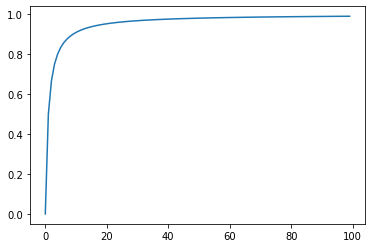

In [61]:
fig = plt.figure()
ax = plt.axes()

x = range(100)
y = [value / (value + 1.0) for value in x]
ax.plot(x, y);

Using this normalization function, we can calculate a fitness value by running the instrumented program under test, and then adding up the normalized values of the relevant branches. However, not every if statement will be executed by every test case. What is the branch distance for a branch that wasn't even executed? We need to make sure that the branch distance for branches that weren't even executed is higher than any of the branch distances observed during execution. Given our normalization, we know this maximum value is 1. Thus, the fitness function could look like this:

In [62]:
def get_fitness_cgi(x):
    # Reset any distance values from previous executions
    global distances_true, distances_false
    distances_true = {}
    distances_false = {}

    # Run the function under test
    try:
        cgi_decode_instrumented(x)
    except BaseException:
        pass

    # Sum up branch distances
    fitness = 0.0
    for branch in [1, 3, 4, 5]:
        if branch in distances_true:
            fitness += normalize(distances_true[branch])
        else:
            fitness += 1.0

    for branch in [2]:
        if branch in distances_false:
            fitness += normalize(distances_false[branch])
        else:
            fitness += 1.0

    return fitness

To see our instrumentation in action, let's calculate fitness values for a couple of example inputs, progressively getting closer to the target.

In [63]:
# Empty string does not even enter the loop
get_fitness_cgi("")

4.5

In [64]:
# String contains no percentage character
get_fitness_cgi("Hello+Reader")

2.9722222222222223

In [65]:
# String contains a percentage character, but no valid hex char
get_fitness_cgi("%UU")

1.9230769230769231

In [66]:
# String contains a percentage character, but only one valid hex char
get_fitness_cgi("%AU")

0.9230769230769231

In [67]:
# String contains a percentage character and two valid hex chars
get_fitness_cgi("%AA")

0.0

### Hillclimbing Valid Hexadecimal Inputs

We have now defined the search space through our `neighbour_strings()` function, and we have derived a new fitness function, so before we can apply the hillclimber to the problem of finding strings that contain valid 2-digit hex codes, the only remaining point is to derive a random starting point, which you've already done previously in the [MutationFuzzer chapter](MutationFuzzer.ipynb):

In [68]:
def random_string(l):
    s = ""
    for i in range(l):
        random_character = chr(random.randrange(32, 127))
        s = s + random_character
    return s

Now we can put it all together and use the identical hillclimbing algorithm again, and just make it generate random strings instead of numbers, and use the new fitness function:

In [69]:
def hillclimb_cgi():
    x = random_string(10)
    fitness = get_fitness_cgi(x)
    print("Initial input: %s at fitness %.4f" % (x, fitness))

    while fitness > 0:
        changed = False
        for (nextx) in neighbour_strings(x):
            new_fitness = get_fitness_cgi(nextx)
            if new_fitness < fitness:
                x = nextx
                fitness = new_fitness
                changed = True
                print("New value: %s at fitness %.4f" % (x, fitness))
                break

        # Random restart if necessary
        if not changed:
            x = random_string(10)
            fitness = get_fitness_cgi(x)

    print("Optimum at %s, fitness %.4f" % (x, fitness))

In [72]:
hillclimb_cgi()

Initial input: }nauoH[Nl| at fitness 2.9722
New value: }nauoG[Nl| at fitness 2.9714
New value: }nauoF[Nl| at fitness 2.9706
New value: }nauoE[Nl| at fitness 2.9697
New value: }nauoD[Nl| at fitness 2.9688
New value: }nauoC[Nl| at fitness 2.9677
New value: }nauoB[Nl| at fitness 2.9667
New value: }nauoA[Nl| at fitness 2.9655
New value: }nauo@[Nl| at fitness 2.9643
New value: }nauo?[Nl| at fitness 2.9630
New value: }nauo>[Nl| at fitness 2.9615
New value: }nauo=[Nl| at fitness 2.9600
New value: }nauo<[Nl| at fitness 2.9583
New value: }nauo;[Nl| at fitness 2.9565
New value: }nauo:[Nl| at fitness 2.9545
New value: }nauo9[Nl| at fitness 2.9524
New value: }nauo8[Nl| at fitness 2.9500
New value: }nauo7[Nl| at fitness 2.9474
New value: }nauo6[Nl| at fitness 2.9444
New value: }nauo5[Nl| at fitness 2.9412
New value: }nauo4[Nl| at fitness 2.9375
New value: }nauo3[Nl| at fitness 2.9333
New value: }nauo2[Nl| at fitness 2.9286
New value: }nauo1[Nl| at fitness 2.9231
New value: }nauo0[Nl| at fitness 2.9

Run the hillclimber a couple of times to see it generate strings with valid hex characters. Sometimes it only takes a couple of steps, sometimes it takes longer, but at the end it always solves the problem and generates the string we want to have.